# Bayesian regression using PyMC and STAN

Report any errors to Joris De Ridder.

## Imports

In [21]:
import sys
print("Python version: ", sys.version)

Python version:  3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]


In [22]:
import numpy as np
import scipy as sp
import pandas as pd
print("NumPy version: ", np.__version__)
print("SciPy version: ", sp.__version__)
print("Pandas version: ", pd.__version__)

NumPy version:  1.24.2
SciPy version:  1.10.0
Pandas version:  1.5.3


In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
print("Statsmodels version: ", sm.__version__)

Statsmodels version:  0.13.5


In [24]:
import pymc as pm
import pytensor
import pytensor.tensor as pt 
print("PyMC version: ", pm.__version__)
print("PyTensor version: ", pytensor.__version__)

PyMC version:  5.1.2
PyTensor version:  2.10.1


In [25]:
import stan
import nest_asyncio
nest_asyncio.apply()
print("PyStan version: ", stan.__version__)

PyStan version:  3.6.0


In [6]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

In [7]:
import arviz as az
print("Arviz version: ", az.__version__)

Arviz version:  0.15.1


In [8]:
import corner
print("Corner version: ", corner.__version__)

Corner version:  2.2.1


## Matplotlib font sizes

In [9]:
plt.rc('font',   size=15)          # controls default text sizes
plt.rc('axes',   titlesize=15)     # fontsize of the axes title
plt.rc('axes',   labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=15)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=15)     # fontsize of the tick labels
plt.rc('legend', fontsize=15)      # legend fontsize
plt.rc('figure', titlesize=15)     # fontsize of the figure title

## Links to documentation on the web

* [PyMC documentation](https://docs.pymc.io)
* [PyMC examples](https://www.pymc.io/projects/examples/en/latest/gallery.html)
* [Stan documentation](https://mc-stan.org/docs/2_26/stan-users-guide/index.html).
* [Stan example models](https://github.com/stan-dev/example-models)
* [A brief guide to Stan's warnings](https://mc-stan.org/misc/warnings.html)

## Contents

* [Basic linear regression [PyMC]](#Basic-linear-regression-with-PyMC)
* [Basic linear regression [Stan]](#Basic-linear-regression-with-Stan)
* [Robust regression using a Student's T-distribution [PyMC]](#Robust-regression-using-a-StudentT-likelihood-with-PyMC)
* [Robust regression using the Hogg et al. approach [PyMC]](#Robust-regression-using-the-Hogg-approach-with-PyMC)
* [Robust regression using the Hogg et al. approach [Stan]](#Robust-regression-using-the-Hogg-approach-with-Stan)
* [Piecewise linear regression [PyMC]](#Piecewise-linear-regression-with-PyMC)
* [Piecewise linear regression [Stan]](#Piecewise-linear-regression-with-Stan)
* [Uncertainties in y and x [Stan]](#Uncertainties-in-y-and-x-with-Stan)
* [Fitting a distribution to a dataset [PyMC]](#Modeling-a-distribution-for-a-dataset-with-PyMC)
* [Logistic regression [Stan]](#Fitting-a-logit-model-with-Stan)
* [Logistic regression [PyMC]](#Fitting-a-logistic-model-with-PyMC)
* [Multinomial logistic model [Stan]](#A-multinomial-logistic-model-with-Stan)
* [Modeling a fraction with Beta [Stan]](#Modeling-a-fraction-with-the-Beta-distribution-with-Stan)
* [Modeling counts with Poisson [PyMC]](#Modeling-counts-with-Poisson-with-PyMC)
* [Modeling counts with Poisson [Stan]](#Modeling-counts-with-Poisson-with-Stan)
* [Modeling counts with Negative Binomial [PyMC]](#Modeling-counts-with-Negative-Binomial-with-PyMC)
* [Modeling counts with Negative Binomial [Stan]](#Modeling-counts-with-Negative-Binomial-with-Stan)
* [Zero-truncated Poisson model [Stan]](#A-zero-truncated-Poisson-model-with-Stan)

## Basic linear regression with PyMC

#### A synthetic dataset:

In [12]:
rng = np.random.default_rng(14)

N = 50
theta0 = 1
theta1 = 2
sigma = 0.3

x = np.linspace(0, 1, N)
y = theta0 + theta1 * x + rng.normal(0.0, sigma, N)

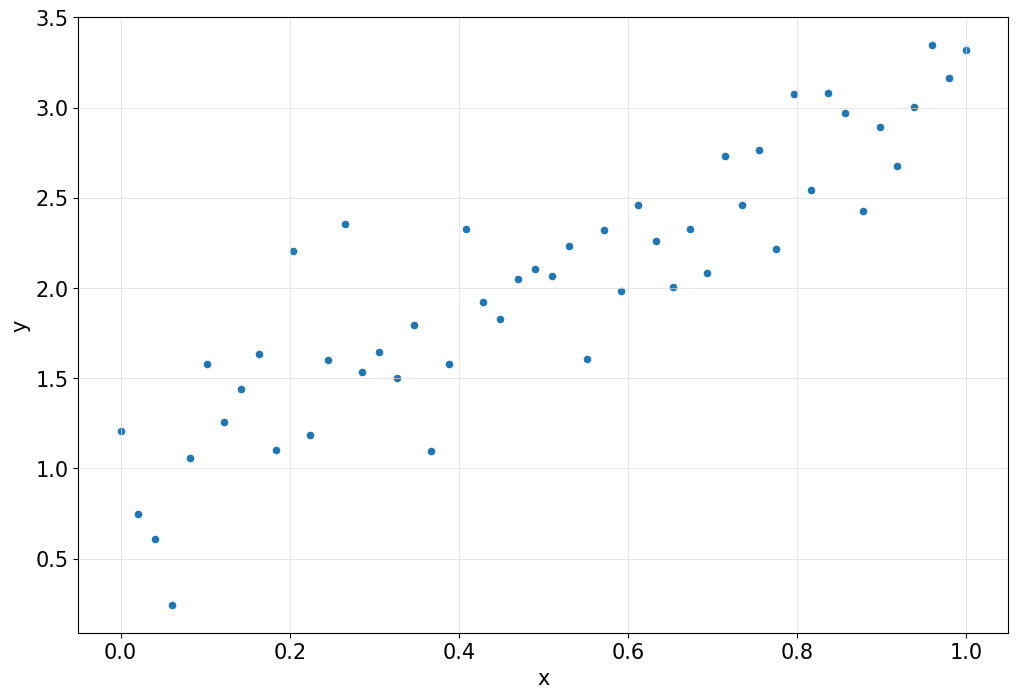

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.scatter(x, y, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### The Bayesian model

Our Bayesian model:

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$


See the [PyMC3 documentation](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.HalfCauchy) on the definition of the HalfCauchy distribution.

In [88]:
with pm.Model() as myModel:
    
    xobs = pm.MutableData("xobs", x)
    yobs = pm.MutableData("yobs", y)
    
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept, angle]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


#### Summary of the trace

In [89]:
az.summary(trace, var_names=['intercept', 'slope', 'sigma'], hdi_prob=0.95, round_to=5)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
intercept  0.95494  0.09736   0.76345    1.14883    0.00142  0.00100   
slope      2.15520  0.16781   1.82795    2.48259    0.00242  0.00171   
sigma      0.34098  0.03616   0.27351    0.41116    0.00044  0.00032   

             ess_bulk    ess_tail    r_hat  
intercept  4779.50469  5282.65667  1.00085  
slope      4824.77880  5183.07410  1.00058  
sigma      6891.92574  6098.48365  1.00011

The mean posterior values of the fit parameters can be obtained as follows:

In [90]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

#### Verify the behavior of the chains

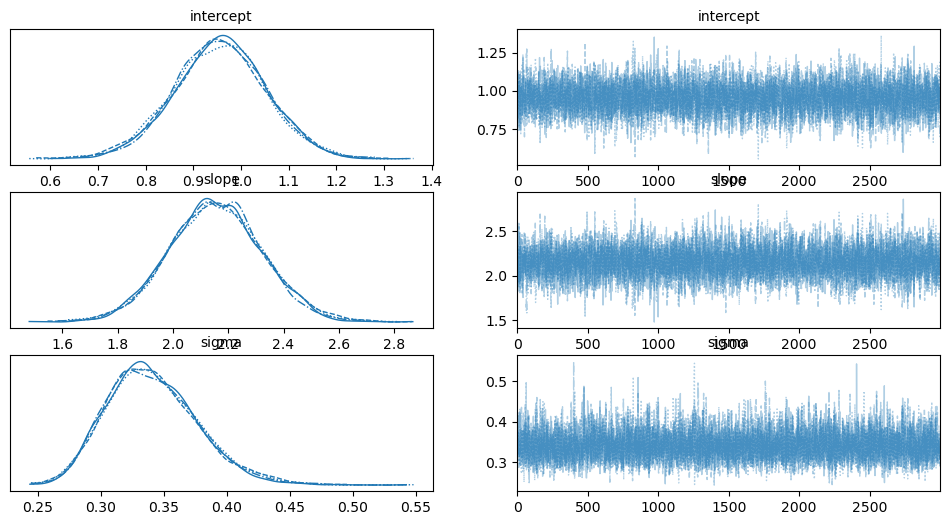

In [91]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

Auto-correlation functions:

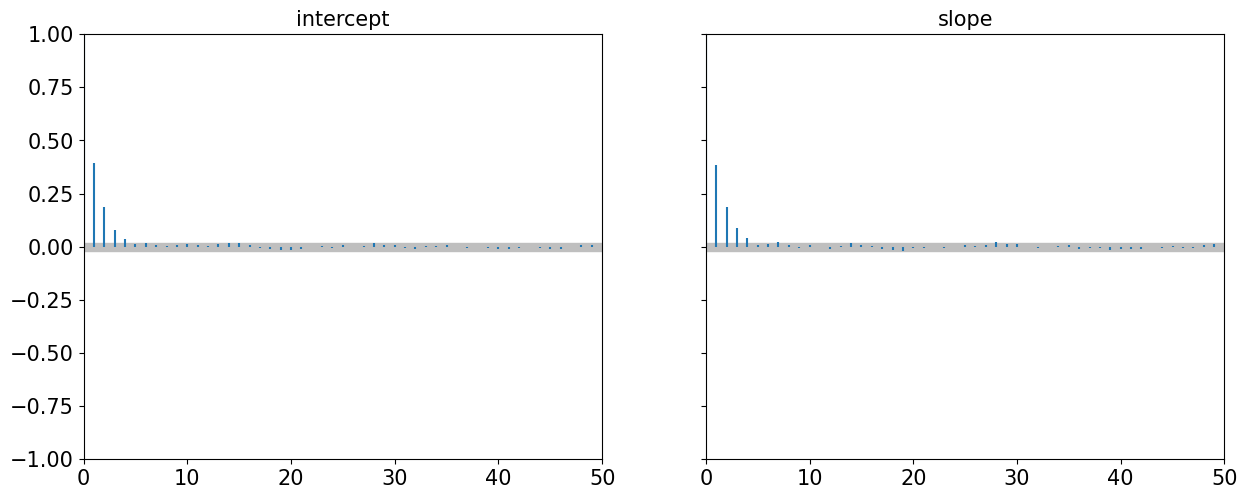

In [92]:
fig = az.plot_autocorr(trace, var_names=("intercept", "slope"), max_lag=50, combined=True)

#### One and two-dimensional projections of the posterior samples

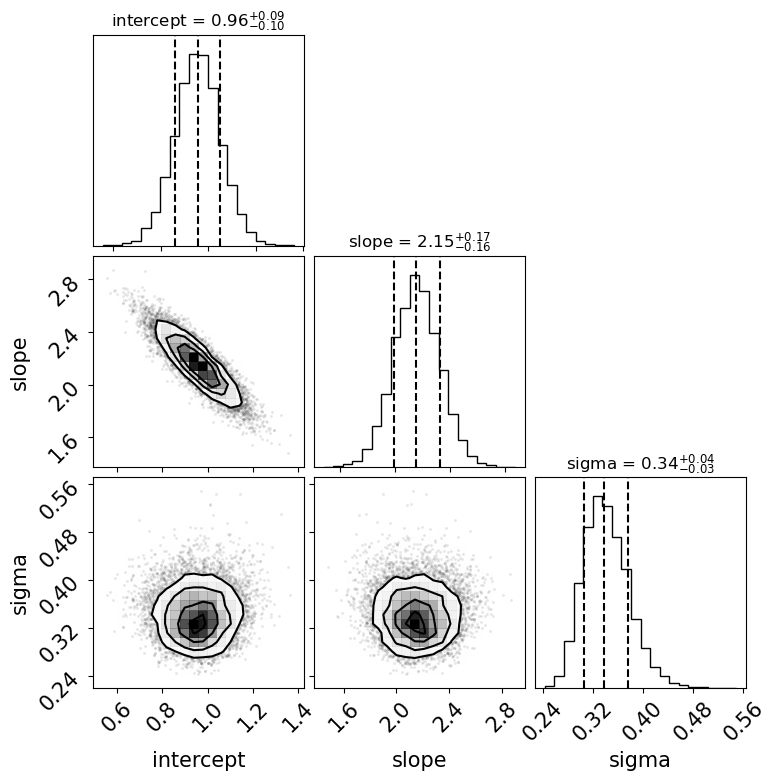

In [93]:
fig, ax = plt.subplots(3,3, figsize=(8,8))                                       # 3 because we're showing 3 params
fig = corner.corner(trace, fig=fig, var_names=['intercept', 'slope', 'sigma'],
                           quantiles=[0.16, 0.5, 0.84],
                           show_titles=True, 
                           title_kwargs={"fontsize": 12})

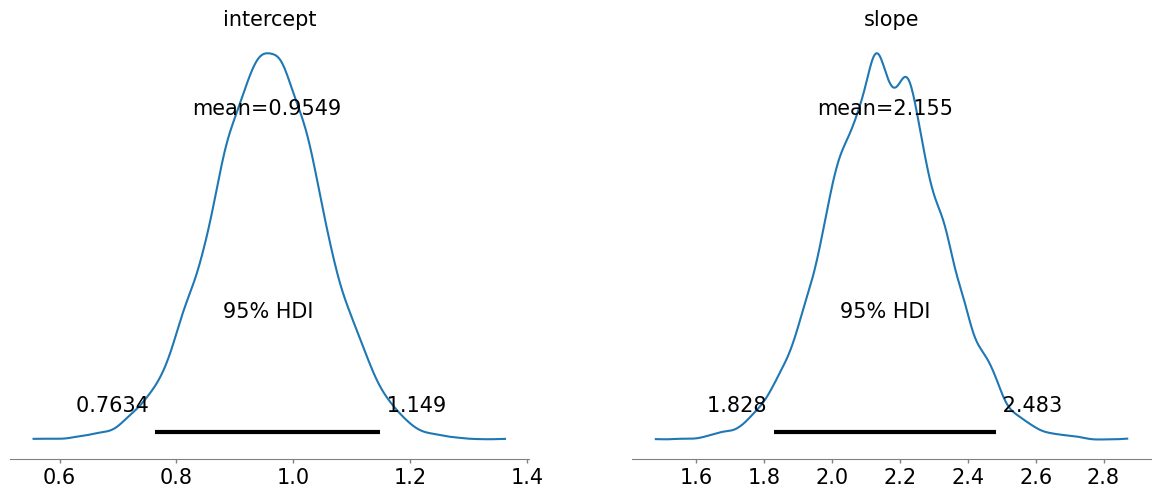

In [94]:
myPlot = az.plot_posterior(trace, var_names=['intercept', 'slope'], point_estimate='mean', hdi_prob=0.95, textsize=15, round_to=4)

Arviz allows to make a 2D contour plot of posterior samples: 

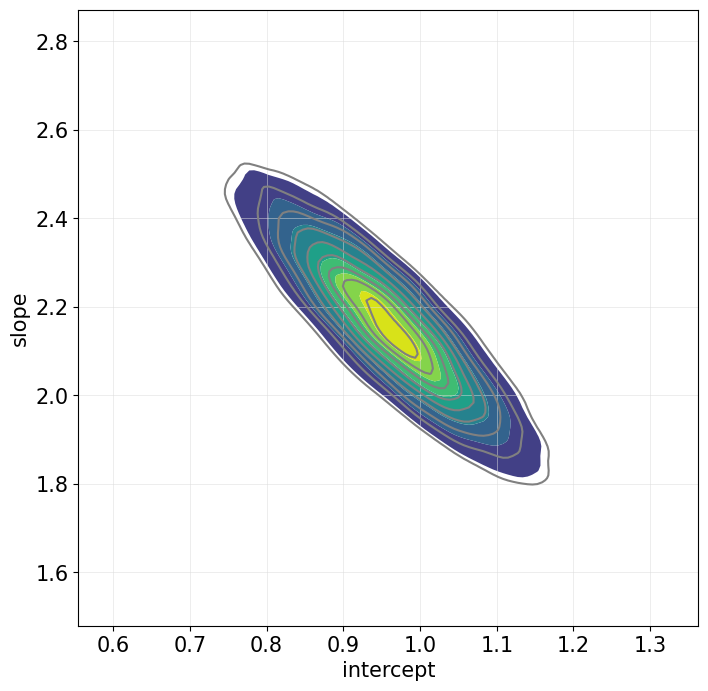

In [95]:
fig, ax = plt.subplots(1,1, figsize=(8,8)) 
kde_kwargs = {'contour_kwargs': {'levels': 10}}
az.plot_pair(trace, ax=ax, var_names=['intercept', 'slope'], kind='kde', kde_kwargs=kde_kwargs);
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5, alpha=0.7)

#### Plotting the posterior model and the data

I first stack all the samples of all chains in one large stack.

In [96]:
stacked = trace.posterior.stack(draws=("chain", "draw"))
slope = stacked.slope.values
intercept = stacked.intercept.values

In [97]:
MAP = pm.find_MAP(model=myModel)
MAPintercept = MAP['intercept']
MAPslope = MAP['slope']
print("MAP value intercept: ", MAPintercept)
print("MAP value slope: ", MAPslope)


MAP value intercept:  0.9440441982003612
MAP value slope:  2.1767289140467674


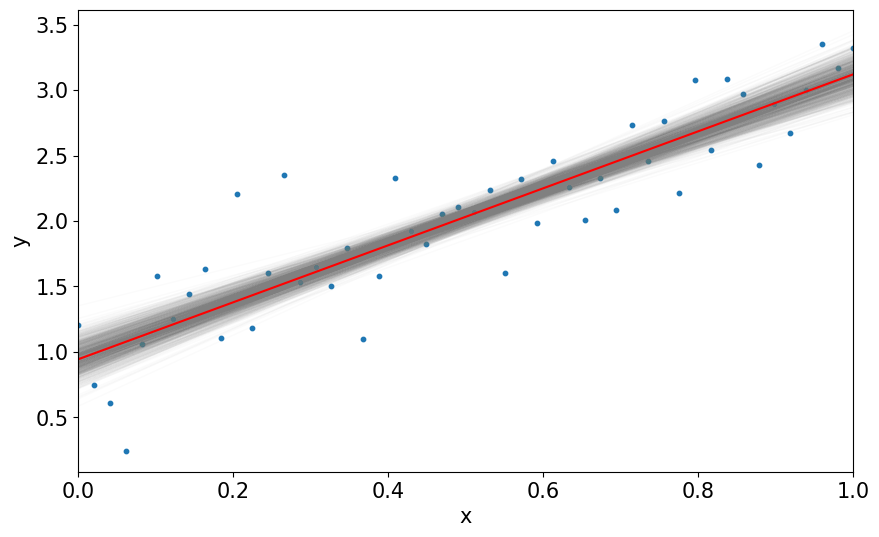

In [98]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 
ax.scatter(x,y, s=10)

M = len(slope)//1000
for n in range(0, len(slope), M):
    ax.plot(x, intercept[n] + slope[n]*x, c="gray", linewidth=1, alpha=0.03)

#ax.plot(x, meanIntercept + meanSlope * x, c="red", linewidth=1.5)
ax.plot(x, MAPintercept + MAPslope * x, c="red", linewidth=1.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
plt.show()

#### Posterior predictive distribution

We aim to compute the posterior predictive distribution for a set of new x-values:

In [107]:
Nnew = 30
xnew = np.linspace(0, 1, Nnew)                        # Our set of new x-values 
with myModel:                                         # Use the same model as before 
   pm.set_data(
   {
      "xobs": xnew,                                  # Reset the x-values
      "yobs": np.zeros_like(xnew)                    # Not needed, but must be same size as xobs
   })

   postPred = pm.sample_posterior_predictive(trace.posterior, return_inferencedata=True)

As usual, the Bayesian result is not a point estimate, but a distribution. For example the ynew distribution for xnew[0] and xnew[10] is:

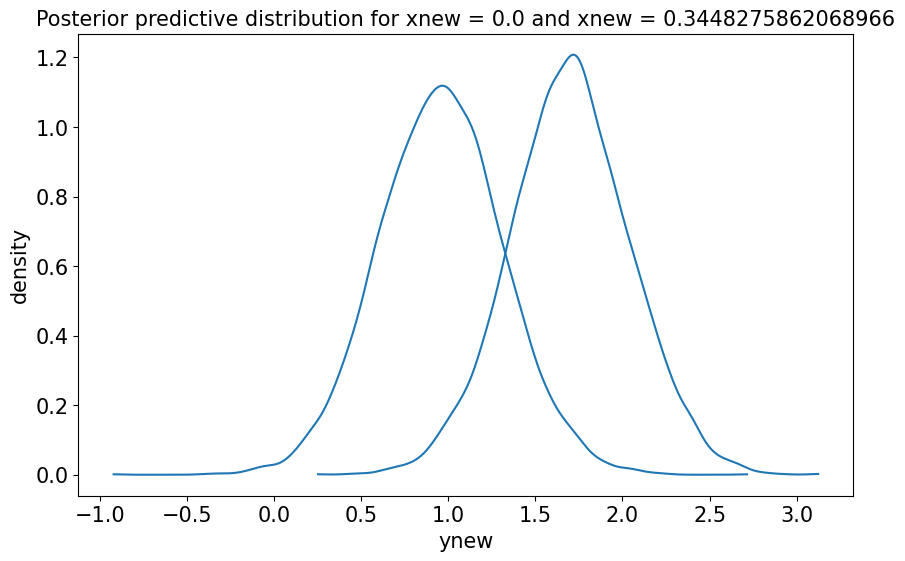

In [127]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
az.plot_kde(np.array(postPred.posterior_predictive['y'][:,:,0]).flatten(), ax=ax)
az.plot_kde(np.array(postPred.posterior_predictive['y'][:,:,10]).flatten(), ax=ax)
ax.set_xlabel("ynew")
ax.set_ylabel("density")
ax.set_title(f"Posterior predictive distribution for xnew = {xnew[0]} and xnew = {xnew[10]}")
plt.show()

Plot the 95% high-density probability.

In [144]:
meanPostPred = postPred.posterior_predictive['y'].mean(axis=(0,1))                        # Average over chains and samples

(0.0, 1.0)

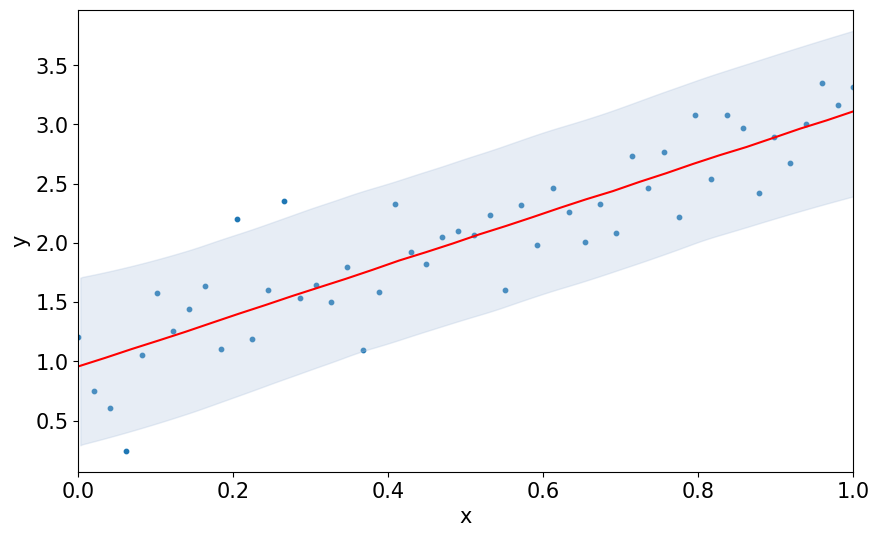

In [150]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x,y, s=10)
ax.plot(xnew, meanPostPred, c="red", linewidth=1.5)
az.plot_hdi(xnew, postPred.posterior_predictive['y'], hdi_prob=0.95, color="lightsteelblue", fill_kwargs={'alpha': 0.3}, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)

How does this compare with a 95% prediction interval obtained using least-squares?

In [148]:
df = pd.DataFrame({'y' : y, 'x': x})
N = len(y)
K = 2
olsFit = sm.OLS.from_formula(formula='y ~ x', data=df).fit()
s2 = np.sum(olsFit.resid**2) / (N-K)                               # Estimated variance of the (homescedastic) noise
covMatrix = olsFit.cov_params()                                    # Covariance matrix of the fit parameters
designX = sm.add_constant(np.column_stack([xnew]))                 # Design matrix
ynew = designX @ olsFit.params                                     # Estimated y-values given the xnew values.

sigma_y = np.zeros_like(xnew)
for n in range(len(xnew)):
    xvec = [1, xnew[n]]
    sigma_y[n] = np.sqrt(xvec @ covMatrix @ xvec + s2)             # Uncertainty on the predicted y-value
   
Tdistrib = sp.stats.t(N-K)                                         # Student's T-distribution
tMultiplier = Tdistrib.ppf(1-0.05/2)                               # 95% prediction interval

lowerPI = ynew - tMultiplier * sigma_y                             # PI stands for Prediction Interval
upperPI = ynew + tMultiplier * sigma_y

Text(0, 0.5, 'y')

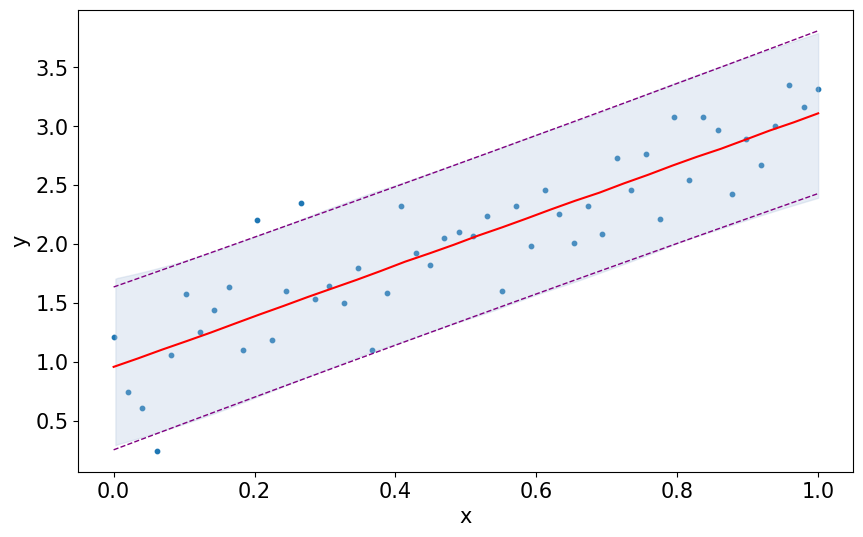

In [152]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x,y, s=10)
ax.plot(xnew, meanPostPred, c="red", linewidth=1.5)
az.plot_hdi(xnew, postPred.posterior_predictive['y'], hdi_prob=0.95, color="lightsteelblue", fill_kwargs={'alpha': 0.3}, ax=ax)   # The Bayesian version
ax.plot(xnew, lowerPI, c="purple", linewidth=1, linestyle='--')                                                                   # The Frequentist versoin
ax.plot(xnew, upperPI, c="purple", linewidth=1, linestyle='--')
ax.set_xlabel("x")
ax.set_ylabel("y")

Back to [contents](#Contents).

---

## Basic linear regression with Stan

We use the same dataset and the same Bayesian model as in the previous example with PyMC3.

In [16]:
rng = np.random.default_rng(14)

N = 50
theta0 = 1
theta1 = 2
sigma = 0.3

x = np.linspace(0, 1, N)
y = theta0 + theta1 * x + rng.normal(0.0, sigma, N)

In [17]:
Nnew = 30
xnew = np.linspace(0, 1, Nnew)                        # x-values for the posterior prediction 

The statements with `Nnew`, `xnew`, and `ynew` are only necessary if you want to do posterior predictive sampling.

In [18]:
code = """
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
  int<lower=1> Nnew;
  vector[Nnew] xnew;
}

parameters {
  real intercept;
  real<lower=-pi()/2, upper=+pi()/2> angle;
  real<lower=0> sigma;
}

transformed parameters{ 
  real slope;
  slope = tan(angle);
}

model {
  intercept ~ normal(0, 20);
  angle     ~ uniform(-pi()/2, +pi()/2);
  sigma     ~ cauchy(0, 3.0);
  y         ~ normal(intercept + slope * x, sigma);
}

generated quantities {
  real ynew[Nnew] = normal_rng(intercept + slope * xnew, sigma);
}
"""

In [19]:
myData = {"N": N, "x": x, "y": y, 'Nnew': Nnew, 'xnew': xnew}

In [20]:
model = stan.build(code, data=myData, random_seed=135)

Building...

Error handling request
Traceback (most recent call last):
  File "/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/aiohttp/web_protocol.py", line 433, in _handle_request
    resp = await request_handler(request)
  File "/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/aiohttp/web_app.py", line 504, in _handle
    resp = await handler(request)
  File "/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/httpstan/views.py", line 103, in handle_create_model
    _, stanc_warnings = httpstan.compile.compile(program_code, stan_model_name)
  File "/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/httpstan/compile.py", line 24, in compile
    with importlib.resources.path(__package__, "stanc") as stanc_binary:
  File "/Users/joris/miniconda3/envs/course/lib/python3.9/contextlib.py", line 119, in __enter__
    return next(self.gen)
  File "/Users/joris/miniconda3/envs/course/lib/python3.9/importlib/resources.py", line 175, in _path_from_rea

ValueError: The JSON document has an improper structure: missing or superfluous commas, braces, missing keys, etc.

The following initialValues are usually redundant, as Stan is pretty good in choosing reasonable values on its own. I include the example, just in case you do want to experiment with initial values. Note that you need to give initial values for each chain (hence 4 dictionary in the list below), and the initial values need to be within the lower/upper constraints you specified in the model above. It's usually **not** a great idea to initialize the sampler with the MAP estimates.

In [31]:
initialValues = [{'intercept': 1, 'angle':np.pi/2.1}, {"intercept": 2, 'angle': np.pi/2.1}, 
                 {'intercept': 1, 'angle':np.pi/2.3}, {"intercept": 1.5, 'angle': np.pi/2.5}]

In [32]:
trace = model.sample(num_chains=4, num_samples=3000, num_warmup=1000, init=initialValues)

Sampling:   0%
Sampling:  25% (4000/16000)
Sampling:  50% (8000/16000)
Sampling:  75% (12000/16000)
Sampling: 100% (16000/16000)
Sampling: 100% (16000/16000), done.
Messages received during sampling:
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000106 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
  Adjust your expectations accordingly!


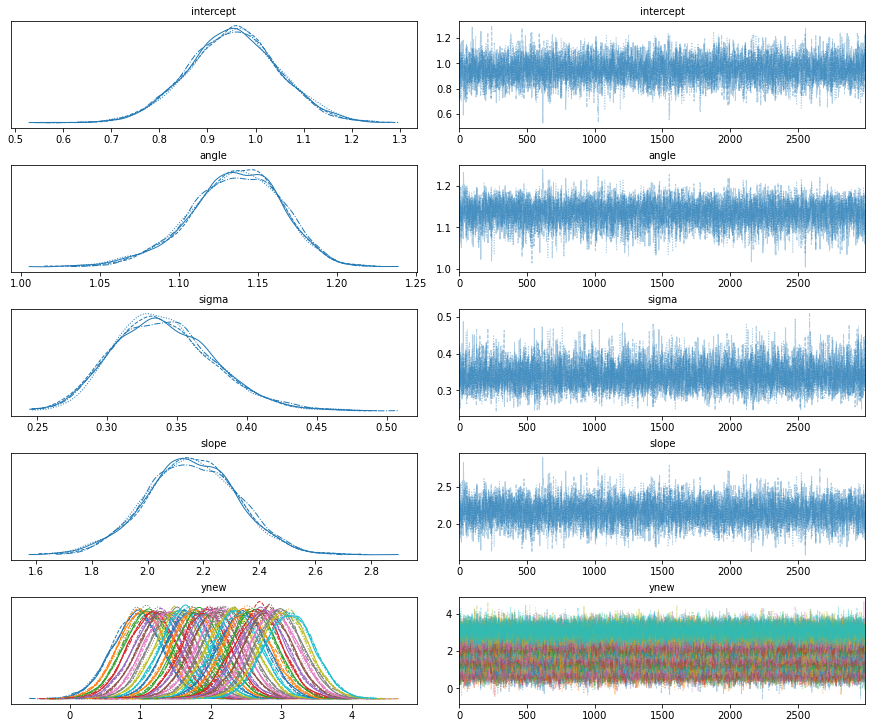

In [33]:
ax = az.plot_trace(trace)

In [34]:
az.summary(trace, var_names=['intercept', 'slope', 'sigma'], round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
intercept  0.95352  0.09504  0.77909  1.13557    0.00139  0.00099  4684.79322   
slope      2.15829  0.16318  1.86592  2.48209    0.00242  0.00171  4545.08246   
sigma      0.34078  0.03581  0.27468  0.40640    0.00047  0.00033  5863.98081   

             ess_tail    r_hat  
intercept  5429.68281  1.00047  
slope      5357.30055  1.00088  
sigma      6330.43889  1.00069

Make a plot with the data, the median of the posterior, and the 2.5% and 97.5% quantiles of the posterior.

In [35]:
median = np.quantile(trace['ynew'], 0.5, axis=1)
lowerQuantile = np.quantile(trace['ynew'], 0.025, axis=1)
upperQuantile = np.quantile(trace['ynew'], 0.975, axis=1)

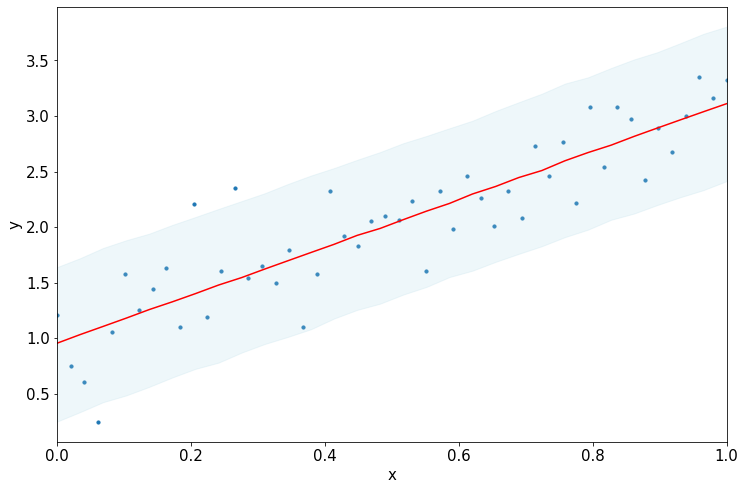

In [36]:
fig, ax = plt.subplots(1,1, figsize=(12,8)) 
ax.scatter(x,y, s=10)
ax.plot(xnew, median, c="red", linewidth=1.5)
ax.fill_between(xnew, lowerQuantile, upperQuantile, color="lightblue", alpha=0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
plt.show()

Back to [contents](#Contents).

---

## Robust regression using a StudentT likelihood with PyMC

Create a synthetic dataset with outliers:

In [153]:
rng = np.random.default_rng(82)
N = 30
x = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * x + theta2 * (x-5)**2     # noiseless
sigma = 1.0                                      # Stdev of the noise
y = mu + rng.normal(0, sigma, N)                 # with noise
y[[0, 2, 7]] += 9                                # 3 outliers
y[[19,21,23,25,28]] -= 9                         # 5 more outliers
data = pd.DataFrame({'y': y, 'x': x})

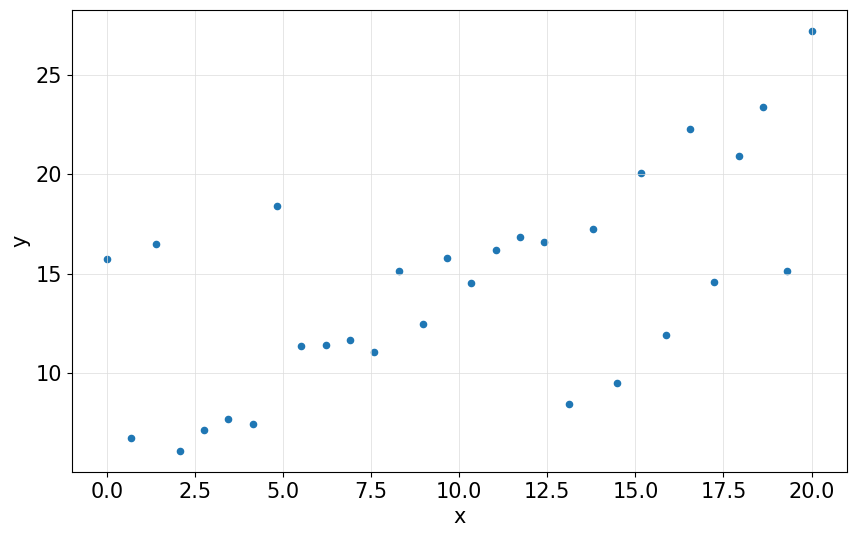

In [155]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### The non-robust Bayesian model

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [156]:
with pm.Model() as myModel:
    
    xobs      = pm.Data("xobs", x)
    yobs      = pm.Data("yobs", y)
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept, angle]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


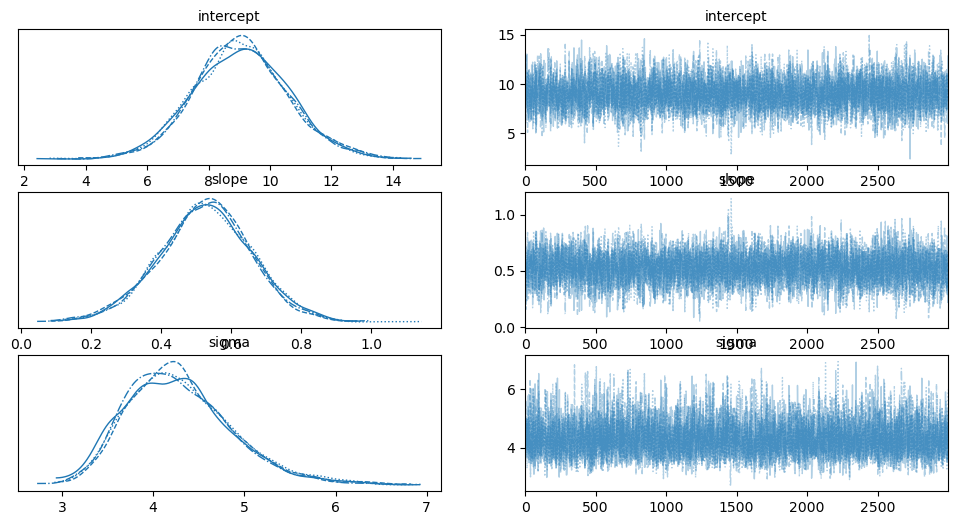

In [157]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

Note the way too high value of $\sigma$.

In [158]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

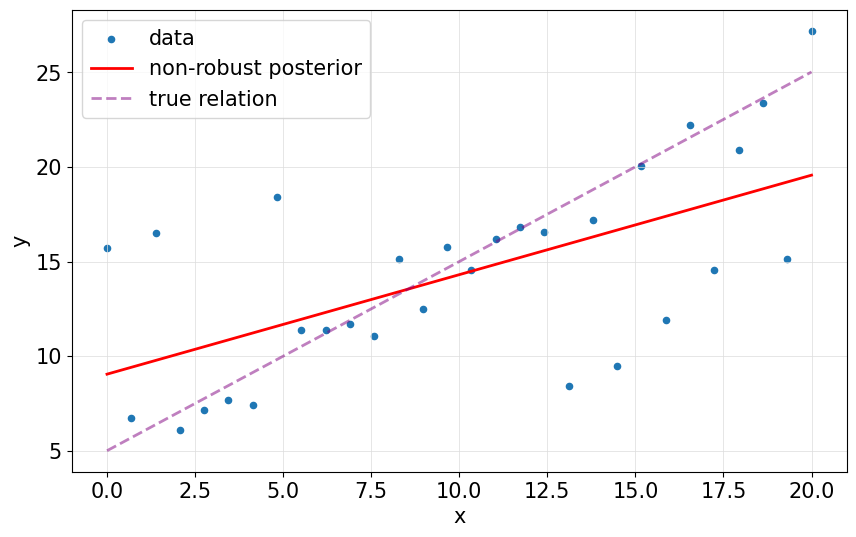

In [160]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="non-robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### A more robust Bayesian model

We use the Student's T-distribution instead of a Gaussian distribution for the likelihood:

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm T}(\mu, \sigma, \nu=1)$

Note that the T-distribution with $\nu=1$ is the Cauchy distribution which has very broad tails.

In [161]:
with pm.Model() as myModel:
    
    xobs      = pm.Data("xobs", x)
    yobs      = pm.Data("yobs", y)
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.StudentT('y', nu=1, mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept, angle]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


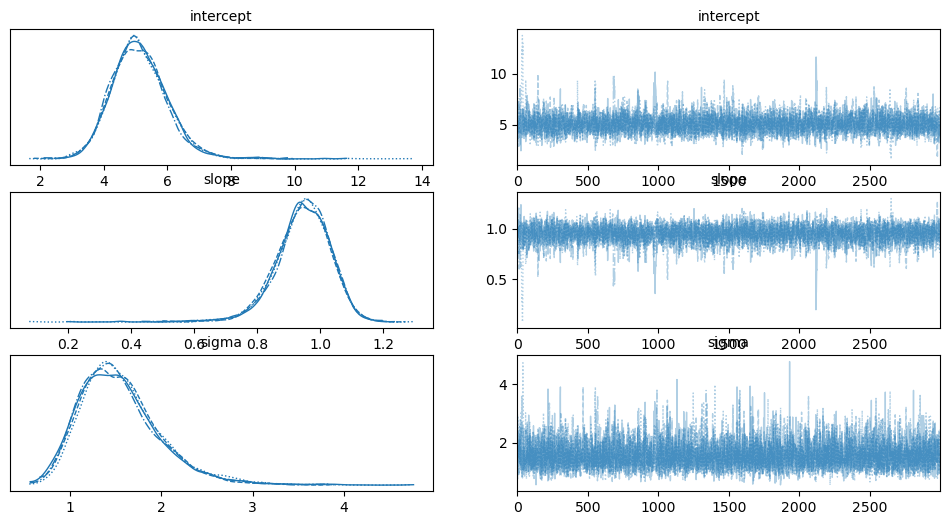

In [162]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

In [163]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

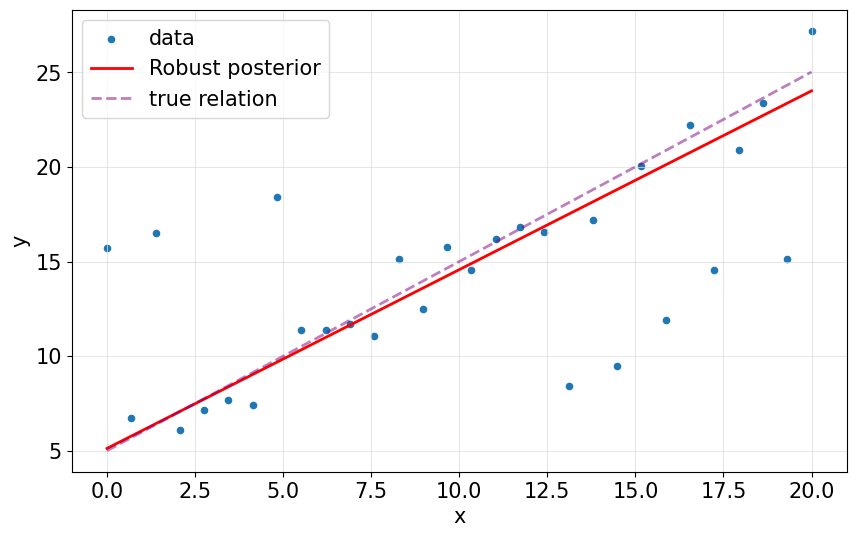

In [165]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="Robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

One can try different values for the parameter $\nu$ of the T-distribution and do a sensitivity analysis. Alternatively, one can include a hyperprior distribution for $\nu$. Gelman et al. (2003) suggests that one might try

$$ \nu^{-1} \sim {\rm Uniform}(0,1) $$

This hyperprior distribution favors long-tailed likelihoods, with half of the prior probability falling between $T(\nu=1)$ and $T(\nu=2)$.

Back to [contents](#Contents).

---

## Robust regression using the Hogg approach with PyMC

We use the same outlier dataset as in the previous example:

In [166]:
rng = np.random.default_rng(82)
N = 30
x = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * x + theta2 * (x-5)**2     # noiseless
sigma = 1.0                                      # Stdev of the noise
y = mu + rng.normal(0, sigma, N)                 # with noise
y[[0, 2, 7]] += 9                                # 3 outliers
y[[19,21,23,25,28]] -= 9                         # 5 more outliers
data = pd.DataFrame({'y': y, 'x': x})

The following code was inspired by the article of [Hogg et al. (2010)](https://arxiv.org/pdf/1008.4686v1.pdf). In particular, see their equation (17). This involves implementing a custom likelihood function using the `pm.DensityDist` feature.

In [178]:
with pm.Model() as myModel:
    
    xobs = pm.Data("xobs", x)
    yobs = pm.Data("yobs", y)
    
    sigmaInlier     = pm.HalfCauchy("sigma", beta=3)
    intercept       = pm.Normal("intercept", 0, sigma=10)
    angle           = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope           = pm.Deterministic("slope", np.tan(angle))   
    muOutlier       = pm.Uniform("muOutlier", -100, +100, initval=0)
    logSigmaOutlier = pm.Uniform("logSigmaOutlier", -5, 5, initval=2)
    probOutlier     = pm.Uniform("probOutlier", 0.0, 1.0, initval=0.1) 
    
    def logLikelihood(y, x, sigmaInlier, intercept, angle, slope, muOutlier, logSigmaOutlier, probOutlier):
        sigmaOutlier = pt.sqrt(pt.exp(logSigmaOutlier)**2 + sigmaInlier**2) 
        muInlier = intercept + slope * x
        LikeInlier = 1./(sigmaInlier * np.sqrt(2*np.pi)) * pt.exp(-0.5 * (y - muInlier)**2 / sigmaInlier**2)
        LikeOutlier = 1./(sigmaOutlier * np.sqrt(2*np.pi)) * pt.exp(-0.5 * (y - muOutlier)**2 / sigmaOutlier**2)
        return pt.sum(pt.log((1 - probOutlier) * LikeInlier + probOutlier * LikeOutlier))

    # Exact order of the arguments in logLiklihood should be copied in DensityDist. 
    likelihood = pm.DensityDist('likelihood', xobs, sigmaInlier, intercept, angle, slope, muOutlier, logSigmaOutlier, probOutlier, logp=logLikelihood, observed=yobs)

    trace = pm.sample(4000, chains=4, cores=2, return_inferencedata=True, tune=2000, target_accept=0.95)

/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept, angle, muOutlier, logSigmaOutlier, probOutlier]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 17 seconds.


Note that I needed to increase the acceptance probability to 0.95. PyMC will adapt the step size such that the average acceptance probability across the trajectories is close to `target_accept`. So, higher values for `target_accept` lead to smaller step sizes.

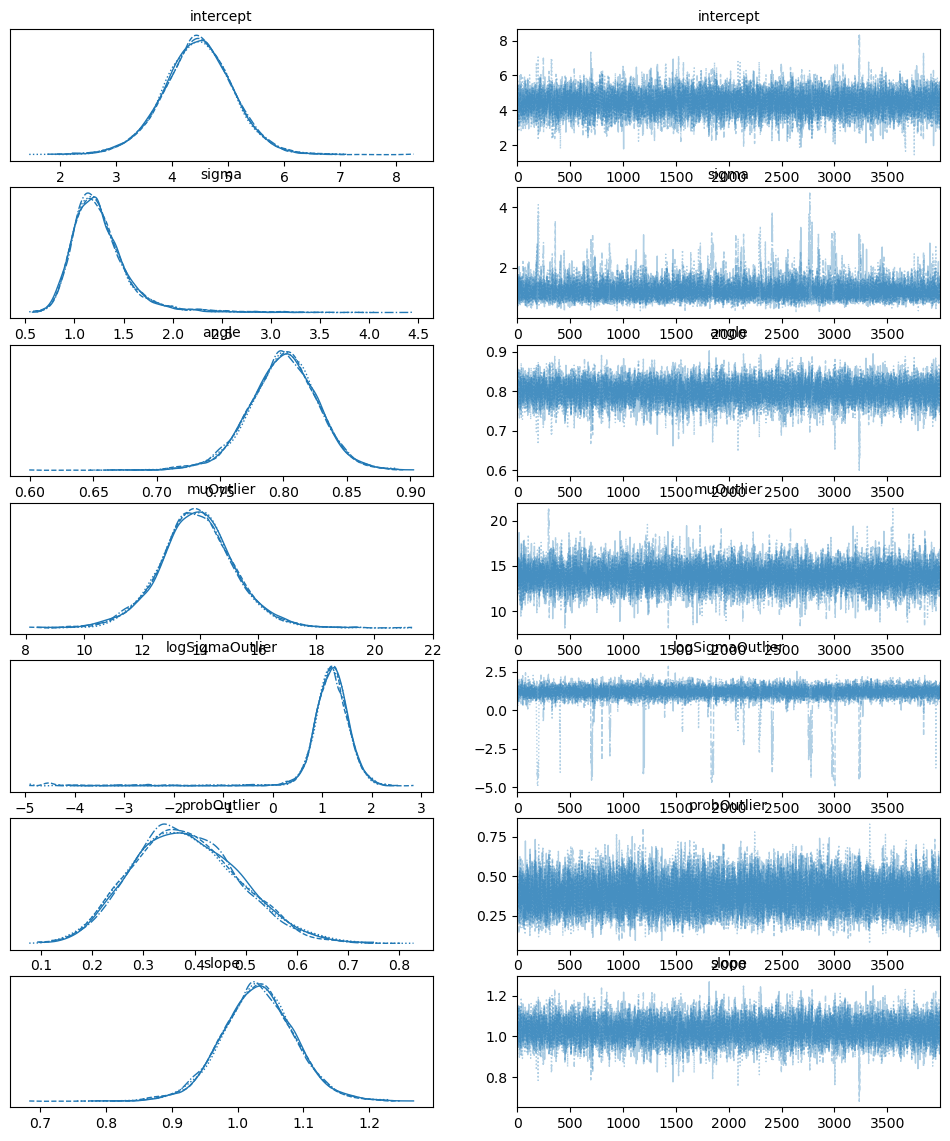

In [179]:
ax = az.plot_trace(trace)

In [180]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

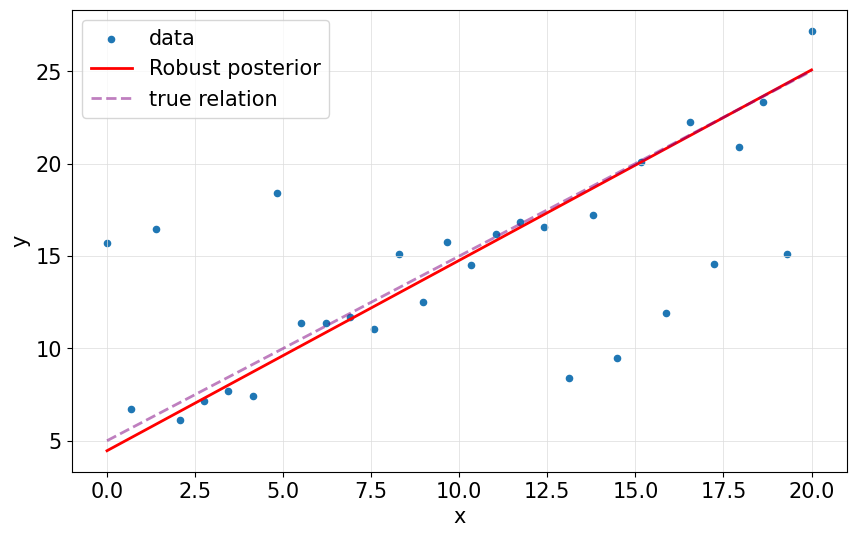

In [182]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="Robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Robust regression using the Hogg approach with Stan

In [58]:
rng = np.random.default_rng(82)
N = 30
x = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * x + theta2 * (x-5)**2     # noiseless
sigma = 1.0                                      # Stdev of the noise
y = mu + rng.normal(0, sigma, N)                 # with noise
y[[0, 2, 7]] += 9                                # 3 outliers
y[[19,21,23,25,28]] -= 9                         # 5 more outliers

The way to make a custom likelihood is to define a function of the form

`real xxxx_lpdf(real y, ...)`

that contains the log-likelihood. However, when using the function, the `_lpdf` extenstion as well as the first argument `y` is ommitted.

In [59]:
code = """
functions {

  real likelihood_lpdf(real y, real x, real sigmaOutlier, real muOutlier, real sigmaInlier, real probOutlier, real intercept, real slope) 
  {
     real muInlier;
     real likeInlier;
     real likeOutlier;
     real logLike;
     
     muInlier = intercept + slope * x;
     likeInlier  = 1./(sigmaInlier  * sqrt(2*pi())) * exp(-0.5 * square(y - muInlier) / square(sigmaInlier));
     likeOutlier = 1./(sigmaOutlier * sqrt(2*pi())) * exp(-0.5 * square(y - muOutlier) / square(sigmaOutlier));  
     logLike = log((1-probOutlier) * likeInlier + probOutlier * likeOutlier);
     
     return logLike; 
  }
}

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}

parameters {
  real intercept;
  real<lower=-pi()/2, upper=+pi()/2> angle;
  real<lower=0> sigmaInlier;
  real logSigmaOutlier;
  real muOutlier;
  real<lower=0, upper=1> probOutlier;
}

transformed parameters{ 
  real slope;
  slope = tan(angle);
  real sigmaOutlier;
  sigmaOutlier = sqrt(square(exp(logSigmaOutlier)) + square(sigmaInlier));
}

model {
  intercept       ~ normal(0, 10);
  angle           ~ uniform(-pi()/2, +pi()/2);
  sigmaInlier     ~ cauchy(0, 2.0);
  muOutlier       ~ uniform(-10, 50);
  logSigmaOutlier ~ uniform(-0.1, 3);
  probOutlier     ~ uniform(0,1);
  
  for (i in 1:N) {
      y[i] ~ likelihood(x[i], sigmaOutlier, muOutlier, sigmaInlier, probOutlier, intercept, slope);
  }
}
"""

In [60]:
myData = {"N": N, "x": x, "y": y}

In [61]:
model = stan.build(code, data=myData, random_seed=135)

Building...
Messages from stanc:
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_lphcljcw/model_noco3sle.stan', line 46, column 2 to column 37:
  Parameter muOutlier is given a uniform distribution. The uniform
  distribution is not recommended, for two reasons: (a) Except when there are
  logical or physical constraints, it is very unusual for you to be sure that
  a parameter will fall inside a specified range, and (b) The infinite
  gradient induced by a uniform density can cause difficulties for Stan's
  sampling algorithm. As a consequence, we recommend soft constraints rather
  than hard constraints; for example, instead of giving an elasticity
  parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_lphcljcw/model_noco3sle.stan', line 46, column 33 to column 35:
  Argument 50 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual 

In [62]:
trace = model.sample(num_chains=4, num_samples=3000, num_warmup=3000, delta=0.99)

Sampling...
     0/24000 [>---------------------------]   0%  1 sec/0     
  2400/24000 [==>-------------------------]  10%  1 sec/6     
  5900/24000 [======>---------------------]  24%  1 sec/3     
  7900/24000 [=========>------------------]  32%  1 sec/3     
 12700/24000 [==============>-------------]  52% 6 secs/11    
 20300/24000 [=======================>----]  84% 6 secs/7     
 24000/24000 [============================] 100% 6 secs/6   Messages received during sampling:
  Gradient evaluation took 6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log prob

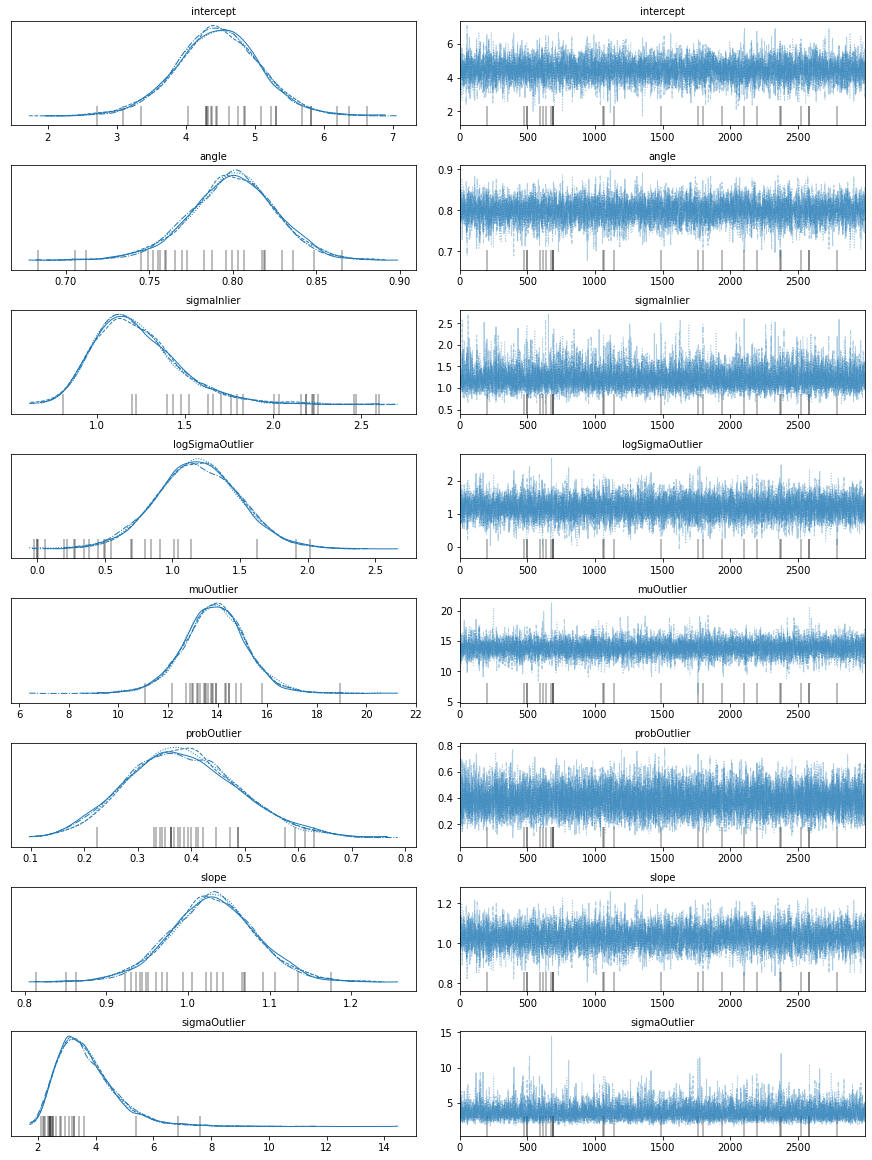

In [63]:
ax = az.plot_trace(trace)

In [64]:
traceframe = trace.to_frame()
print("Nr of divergences: ", traceframe['divergent__'].sum())

Nr of divergences:  26.0


In [65]:
meanIntercept = np.mean(trace['intercept'])
meanSlope = np.mean(trace['slope'])

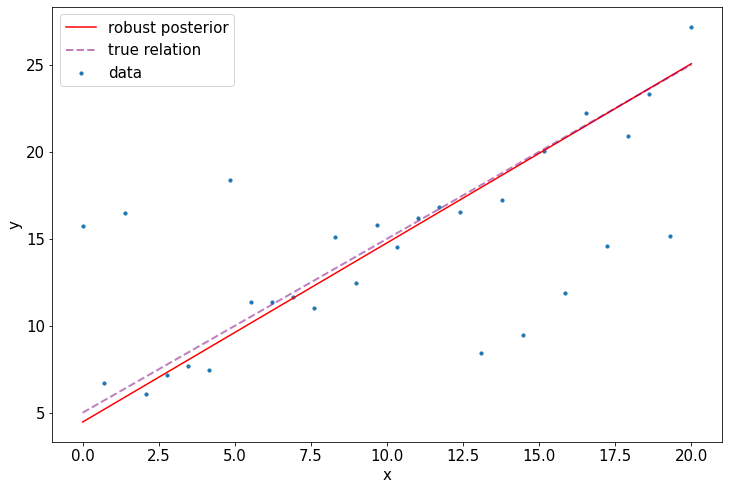

In [66]:
fig, ax = plt.subplots(1,1, figsize=(12,8)) 
ax.scatter(x,y, s=10, label="data")

xvalues = np.linspace(0, 20, 30)
yvalues = meanIntercept + meanSlope * xvalues;
ax.plot(xvalues, yvalues, c="red", linewidth=1.5, label="robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Back to [contents](#Contents).

---

## Piecewise linear regression with PyMC

Create an artificial dataset

In [183]:
rng = np.random.default_rng(149)

N = 50
intercept1 = 1
slope1 = 2
intercept2 = 3.275
slope2 = -1.5

sigma = 0.15

x = np.linspace(0, 2, N)

piece1 = x < 0.65
piece2 = x >= 0.65
y = np.zeros(N)
y[piece1] = intercept1 + slope1 * x[piece1] 
y[piece2] = intercept2 + slope2 * x[piece2] 
y += rng.normal(0.0, sigma, N)

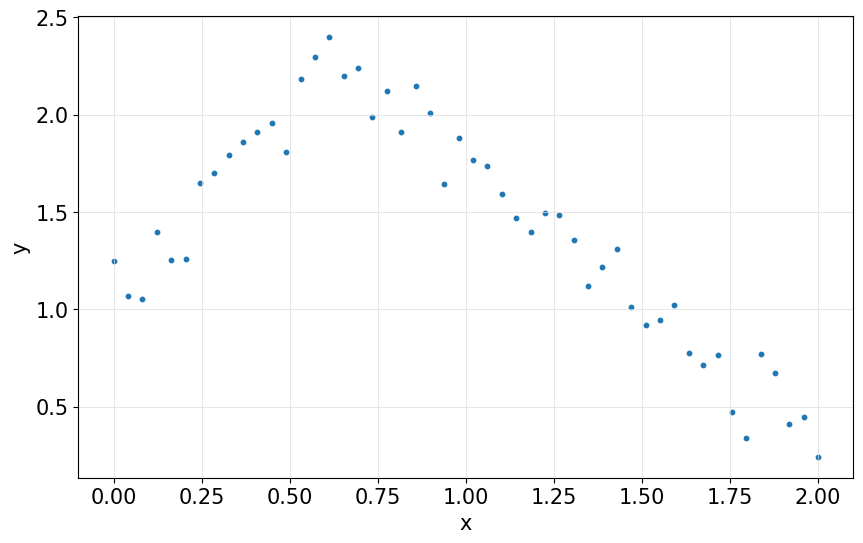

In [185]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The goal is not only to derive the intercepts and the slopes of the linear pieces, but also the location of the switch point.

Our Bayesian model:

$\mu = \theta_0+\theta_1 x$   if $x <= x_0$

$\mu = \theta_2+\theta_3 x$   if $x > x_0$

$\theta_1 = \tan(\alpha_1)$

$\theta_3 = \tan(\alpha_2)$

$\alpha_1 \sim {\rm Uniform}(0, \pi/2)$ 

$\alpha_2 \sim {\rm Uniform}(-\pi/2, 0)$ 

$\theta_0 \sim {\rm Normal}(0, 5)$

$\theta_2 \sim {\rm Normal}(0, 5)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [191]:
with pm.Model() as myModel:

    xobs        = pm.Data("xobs", x, mutable=False)
    yobs        = pm.Data("yobs", y, mutable=False)
    sigma       = pm.HalfCauchy("sigma", beta=2)
    intercept1  = pm.Normal("intercept1", 0, sigma=5)
    intercept2  = pm.Normal("intercept2", 0, sigma=5)
    angle1      = pm.Uniform("angle1", 0, +np.pi/2)
    angle2      = pm.Uniform("angle2", -np.pi/2, 0)
    slope1      = pm.Deterministic('slope1', np.tan(angle1))
    slope2      = pm.Deterministic('slope2', np.tan(angle2))
    switchpoint = pm.Normal('switchpoint', 0.6, 0.25) 
    intercept   = pm.math.switch(x <= switchpoint, intercept1, intercept2)
    slope       = pm.math.switch(x <= switchpoint, slope1, slope2)
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(2000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept1, intercept2, angle1, angle2, switchpoint]


ValueError: Not enough samples to build a trace.

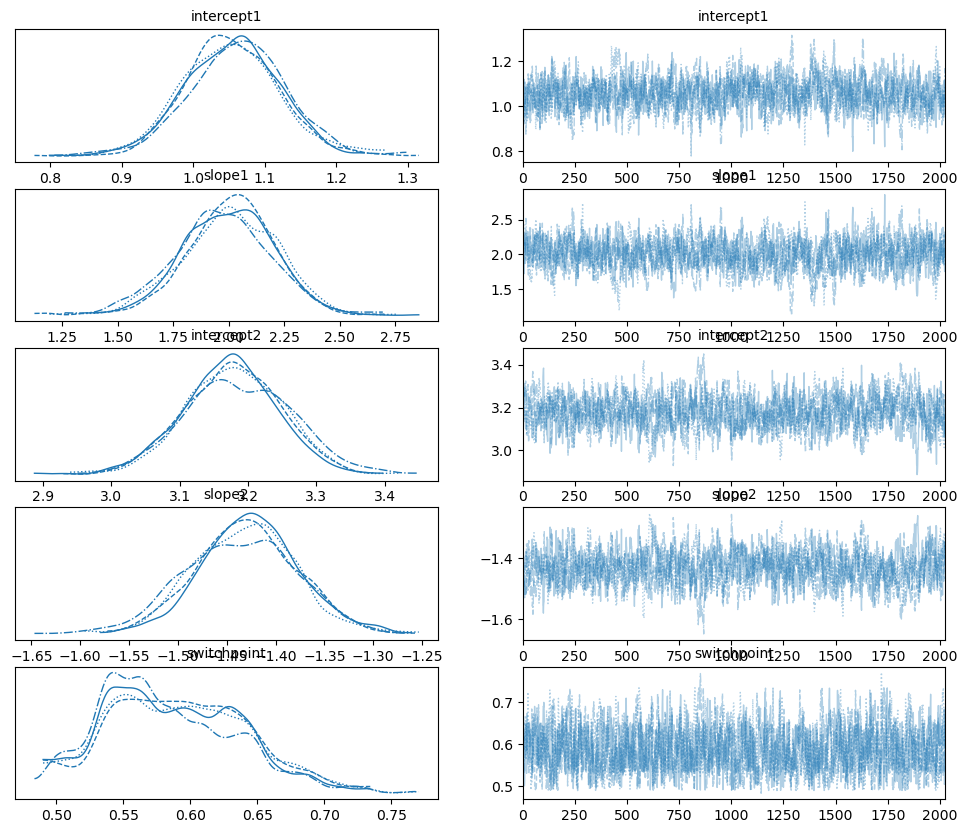

In [190]:
ax = az.plot_trace(trace, var_names=['intercept1', 'slope1', 'intercept2', 'slope2', 'switchpoint'])

In [71]:
az.summary(trace, round_to=3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
intercept1   1.060  0.064   0.942    1.184      0.001    0.001  4701.911   
intercept2   3.192  0.074   3.054    3.331      0.001    0.001  5266.383   
switchpoint  0.593  0.051   0.499    0.689      0.001    0.000  6654.594   
sigma        0.128  0.014   0.102    0.153      0.000    0.000  6948.493   
angle1       1.101  0.043   1.021    1.177      0.001    0.000  4079.871   
angle2      -0.963  0.018  -0.996   -0.930      0.000    0.000  5283.516   
slope1       1.984  0.203   1.597    2.362      0.003    0.002  4359.552   
slope2      -1.440  0.054  -1.538   -1.335      0.001    0.001  5289.505   

               ess_sd  ess_bulk  ess_tail  r_hat  
intercept1   4632.830  4735.077  5380.523  1.001  
intercept2   5266.383  5267.724  7027.334  1.000  
switchpoint  6642.087  6690.818  9041.030  1.000  
sigma        6895.079  7070.534  8498.076  1.001  
angle1       4079.871  4465.969  4375.515  1.000  
angle2       5283.516  5296.608  6931.881  1.000  
slope1       4359.552  4465.969  4375.515  1.000  
slope2       5289.505  5296.608  6931.881  1.000

Back to [contents](#Contents).

---

## Piecewise linear regression with Stan

We use the same dataset and Bayesian model as in the previous example.

In [72]:
code = \
"""
data {
  int<lower=1> N;      
  vector[N] x;
  vector[N] y;
}

parameters {
  real intercept1;
  real intercept2;
  real<lower=0, upper=pi()/2>  angle1;
  real<lower=-pi()/2, upper=0> angle2;
  real<lower=0> sigma;
  real switchpoint;
} 

transformed parameters{
  real slope1;
  real slope2;
  
  slope1 = tan(angle1);
  slope2 = tan(angle2);
}

model {
  intercept1  ~ normal(0, 20);
  intercept2  ~ normal(0, 20);
  angle1      ~ uniform(0, pi()/2);
  angle2      ~ uniform(-pi()/2, 0);
  switchpoint ~ uniform(0.45, 0.9);
  sigma       ~ cauchy(0, 3.0);
    
  for (i in 1:N) {
    if (x[i] < switchpoint) {
       y[i] ~ normal(intercept1 + slope1 * x[i], sigma);
    }
    else {
       y[i] ~ normal(intercept2 + slope2 * x[i], sigma);
    }
  }
}
"""

In [73]:
myData = {"N": N, "x": x, "y": y}

In [74]:
model = stan.build(code, data=myData, random_seed=135)

Building...
Messages from stanc:
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_6lmwjwqz/model_6gfl43hu.stan', line 26, column 26 to column 28:
  Argument 20 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_6lmwjwqz/model_6gfl43hu.stan', line 27, column 26 to column 28:
  Argument 20 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_6lmwjwqz/model_6gfl43hu.stan', line 30, column 2 to column 35:
  Parameter switchpoint is given a uniform distribution. The uniform
  distribution is not recommended, for two reasons: (a) Except when there are
  logical or physical constraints, it is very unusual for you to be sure that
  a parameter will fall inside a specified range, and (b) The i

In [75]:
trace = model.sample(num_chains=4, num_samples=3000)

Sampling...
     0/16000 [>---------------------------]   0%  1 sec/0     
  1000/16000 [=>--------------------------]   6%  1 sec/17    
  1600/16000 [==>-------------------------]  10%  1 sec/17    
  2500/16000 [====>-----------------------]  15% 3 secs/17    
  3200/16000 [=====>----------------------]  20% 4 secs/18    
  3400/16000 [=====>----------------------]  21% 47 secs/219   
  6600/16000 [===========>----------------]  41% 2 mins/147    
 16000/16000 [============================] 100% 2 mins/60    Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this ini

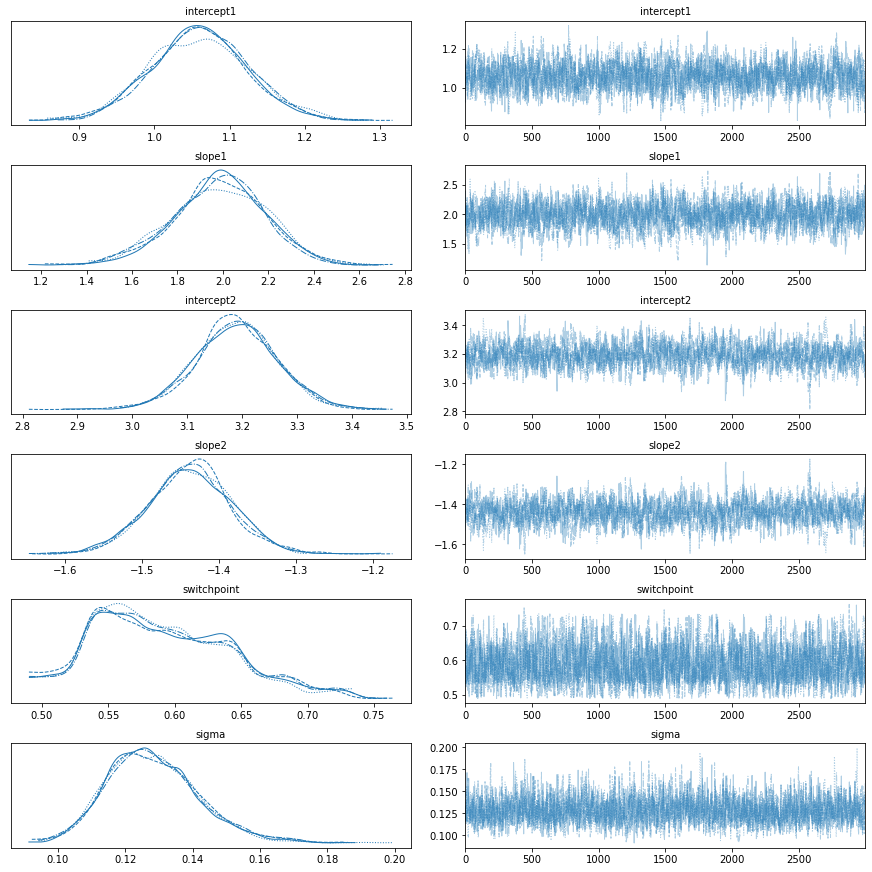

In [76]:
ax = az.plot_trace(trace, var_names=['intercept1', 'slope1', 'intercept2', 'slope2', 'switchpoint', 'sigma'], divergences=None)

In [77]:
az.summary(trace, var_names=['intercept1', 'slope1', 'intercept2', 'slope2', 'switchpoint', 'sigma'], round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept1   1.05982  0.06400  0.94240  1.18381    0.00207  0.00147   
slope1       1.98351  0.20308  1.60019  2.36526    0.00675  0.00477   
intercept2   3.19046  0.07417  3.04955  3.32878    0.00250  0.00177   
slope2      -1.43824  0.05388 -1.53989 -1.33778    0.00181  0.00128   
switchpoint  0.58975  0.05155  0.49725  0.68620    0.00136  0.00096   
sigma        0.12825  0.01364  0.10390  0.15424    0.00031  0.00022   

               ess_mean      ess_sd    ess_bulk    ess_tail    r_hat  
intercept1    954.28924   950.22297   956.24517  1635.75110  1.00451  
slope1        904.98275   904.98275   916.92506  1406.58261  1.00510  
intercept2    879.41493   879.41493   879.18761  1762.61114  1.00144  
slope2        882.52111   882.52111   882.02841  1738.85912  1.00123  
switchpoint  1434.22757  1434.22757  1440.02040  2437.69047  1.00271  
sigma        1940.96929  1940.96929  1925.80130  3220.36725  1.00140

Back to [contents](#Contents).

---

## Uncertainties in y and x with Stan

See also the [Stan documentation on this topic](https://mc-stan.org/docs/2_19/stan-users-guide/bayesian-measurement-error-model.html).

Load the dataset. 

In [78]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/M_sigma.csv"
data = pd.read_csv(url, comment='#')

In [79]:
data.head()

xobs   xerr  yobs   yerr Type
0 -0.279841  0.100  6.61  0.040    S
1 -0.425969  0.015  6.46  0.090    E
2 -0.096910  0.040  8.18  0.150    S
3 -0.289883  0.094  7.00  0.300    S
4  0.019116  0.050  8.23  0.205    E

In [80]:
myData = {'N':len(data)}
for name in ['xobs', 'xerr', 'yobs', 'yerr']:
    myData[name] = data[name].values

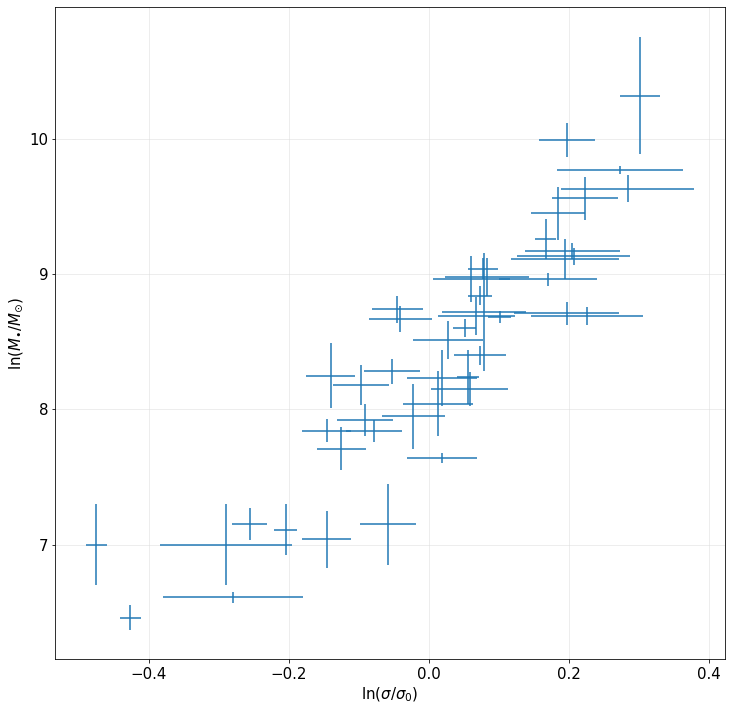

In [81]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)
ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\bullet}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

We will approximate the relation between $y_{\rm true}$ and $x_{\rm true}$ with a simple linear model, but we recognize that we're not very certain of this relation, and that the true relation may deviate from a linear one. We model this uncertainty with

$ y_{\rm true} = \theta_0 + \theta_1\, x_{\rm true} + \mathcal{N}(0, \zeta) $

Since we don't have a clue how large $\zeta$ may be, we take a broad half StudentT distribution:

$ \zeta \sim {\rm HalfStudentT}(\nu=1, \mu=0, \sigma=4) $

We have measurement errors on both $x$ and $y$ which we model with

$ y_{\rm obs} \sim \mathcal{N}(y_{\rm true}, \sigma_y) $

$ x_{\rm obs} \sim \mathcal{N}(x_{\rm true}, \sigma_x) $

where we take $\sigma_x = {\rm xerr}$ and $\sigma_y = {\rm yerr}$, the observed uncertainties. For the prior on $x_{\rm true}$ we take an extremely broad distribution to be uninformative:

$ x_{\rm true} \sim \mathcal{N}(0, 20) $.


In [82]:
code = \
"""
data {
  int<lower=1> N;                                      // number of data points
  vector[N] xobs;                                      // observed velocity dispersion
  vector[N] xerr;                                      // uncertainty on observed velocity scatter
  vector[N] yobs;                                      // observed black hole mass
  vector[N] yerr;                                      // uncertainty on black hole mass
}

parameters {
  real intercept;                                      
  real slope;                                          
  real<lower=0> zeta;                                  // scatter of ytrue around the linear relation
  vector[N] xtrue;                                     // true but unknown velocity dispersion
  vector[N] ytrue;                                     // true but unknown black hole mass 
}

model {
  intercept ~ normal(0, 100);
  slope     ~ normal(0, 100);
  zeta      ~ student_t(1, 0, 4);
  xtrue     ~ normal(0, 20);                           // hyper-prior
  xobs      ~ normal(xtrue, xerr);
  ytrue     ~ normal(intercept + slope * xtrue, zeta);
  yobs      ~ normal(ytrue, yerr);
}
"""

In [83]:
model = stan.build(code, data=myData, random_seed=525)

Building...
Messages from stanc:
  The parameter ytrue has no priors.
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_kg7h09j0/model_pdkwhhvv.stan', line 19, column 24 to column 27:
  Argument 100 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_kg7h09j0/model_pdkwhhvv.stan', line 20, column 24 to column 27:
  Argument 100 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_kg7h09j0/model_pdkwhhvv.stan', line 22, column 24 to column 26:
  Argument 20 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Found model in cache. Done.


In [84]:
trace = model.sample(num_chains=3, num_samples=4000)

Sampling...
     0/15000 [>---------------------------]   0%  1 sec/0     
 10000/15000 [==================>---------]  66%  1 sec/1     
 15000/15000 [============================] 100%  1 sec/0   Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!

 15000/15000 [============================] 100%  1 sec/1     
Done.


In [86]:
az.summary(trace, var_names=['intercept', 'slope', 'zeta'], round_to=3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_mean  \
intercept  8.348  0.058   8.242    8.460      0.000    0.000  16170.370   
slope      4.449  0.335   3.831    5.086      0.003    0.002  11129.697   
zeta       0.285  0.059   0.176    0.397      0.001    0.001   4085.340   

              ess_sd   ess_bulk  ess_tail  r_hat  
intercept  16170.370  16238.118  9781.859    1.0  
slope      11129.697  11136.384  9443.976    1.0  
zeta        4085.340   3980.299  4680.015    1.0

In [87]:
meanIntercept = np.mean(trace['intercept'])
meanSlope = np.mean(trace['slope'])

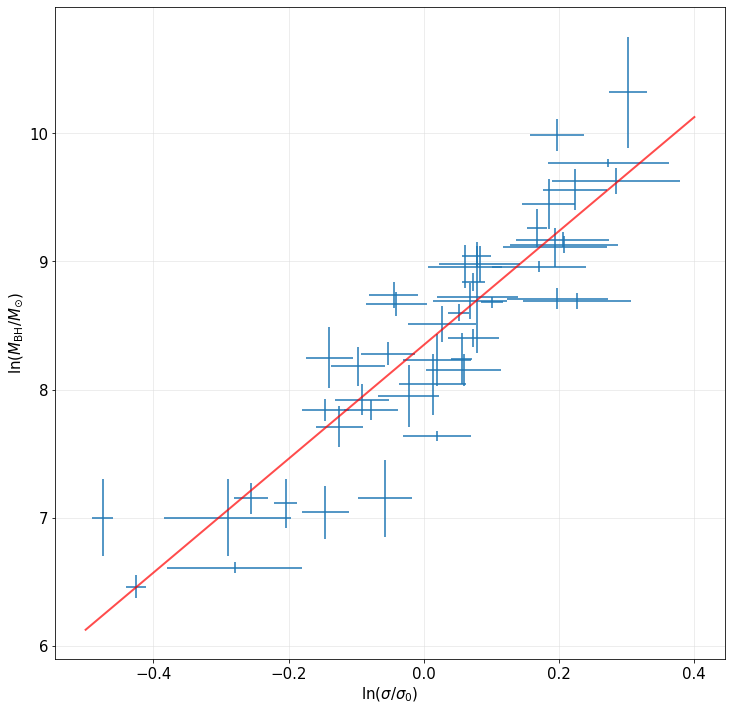

In [88]:
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)

xvalues = np.linspace(-0.5, 0.4, 30)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, alpha=0.7)

ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\rm BH}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling a distribution for a dataset with PyMC

Load the dataset:

In [192]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/NGC6611.csv"
data = pd.read_csv(url, comment='#')

In [193]:
data.head()

Mass
0  0.678
1  0.402
2  0.132
3  0.270
4  0.284

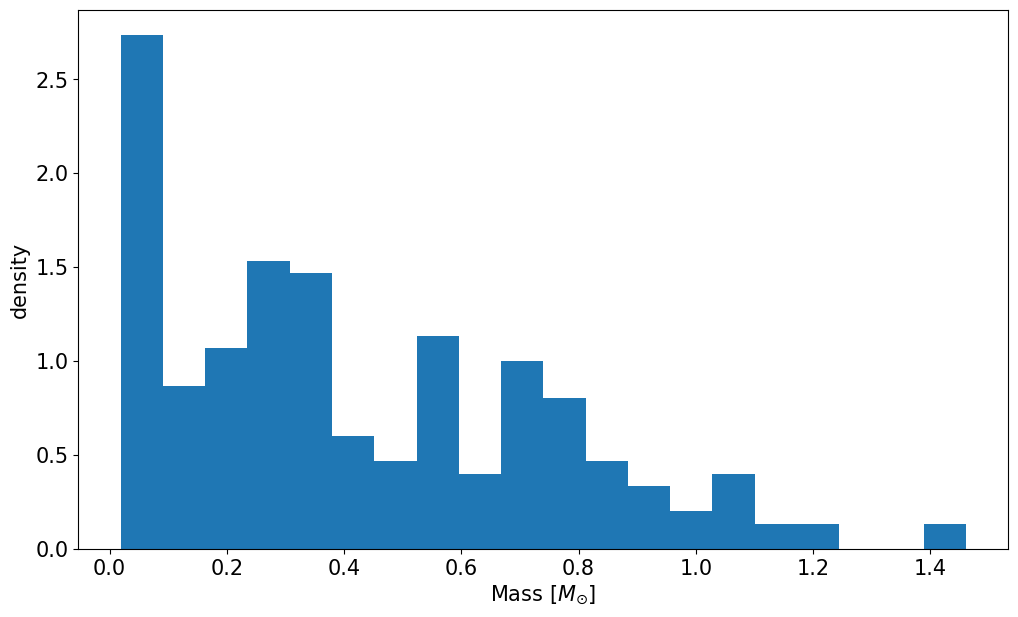

In [194]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.hist(data['Mass'].values, bins=20, density=True)
ax.set_xlabel(r"Mass $[M_{\odot}]$")
ax.set_ylabel("density")
plt.show()

We wish to fit a log-normal distribution:
    
$$f_X(x) = \frac{1}{x\sigma\sqrt{2\pi}} \ \exp\left(-\frac{(\ln x - \mu)^2}{2\sigma^2} \right)$$

$y \sim $ log-Normal $(\mu, \sigma^2)$

$\mu \sim {\rm Normal}(0, 10)$

$\sigma^2 \sim$ HalfNormal $(0, 10^2)$

In [195]:
with pm.Model() as myModel:
    
    yobs = pm.Data("yobs", data['Mass'].values)
    
    mu         = pm.Normal("mu", mu=0, sigma=10)
    sigma      = pm.HalfNormal("sigma", sigma=100)
    likelihood = pm.Lognormal("Mass", mu=mu, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


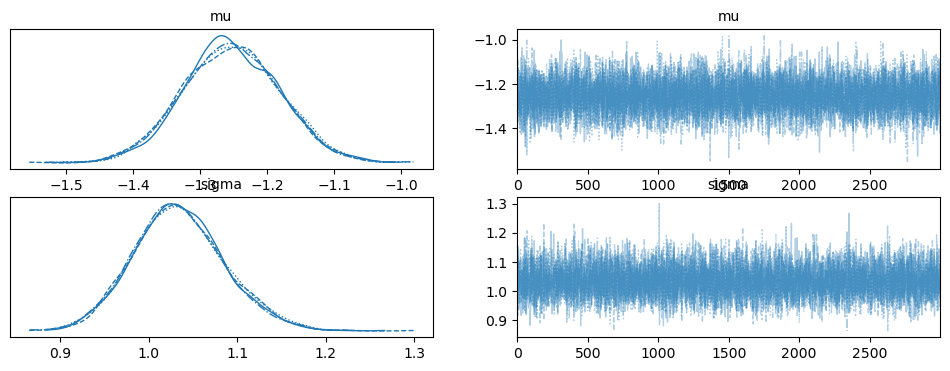

In [196]:
ax = az.plot_trace(trace)

In [197]:
az.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95, round_to=3)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd   ess_bulk  \
mu    -1.253  0.072    -1.397     -1.117      0.001      0.0  12226.731   
sigma  1.034  0.051     0.937      1.139      0.000      0.0  11842.350   

       ess_tail  r_hat  
mu     8541.041    1.0  
sigma  8172.417    1.0

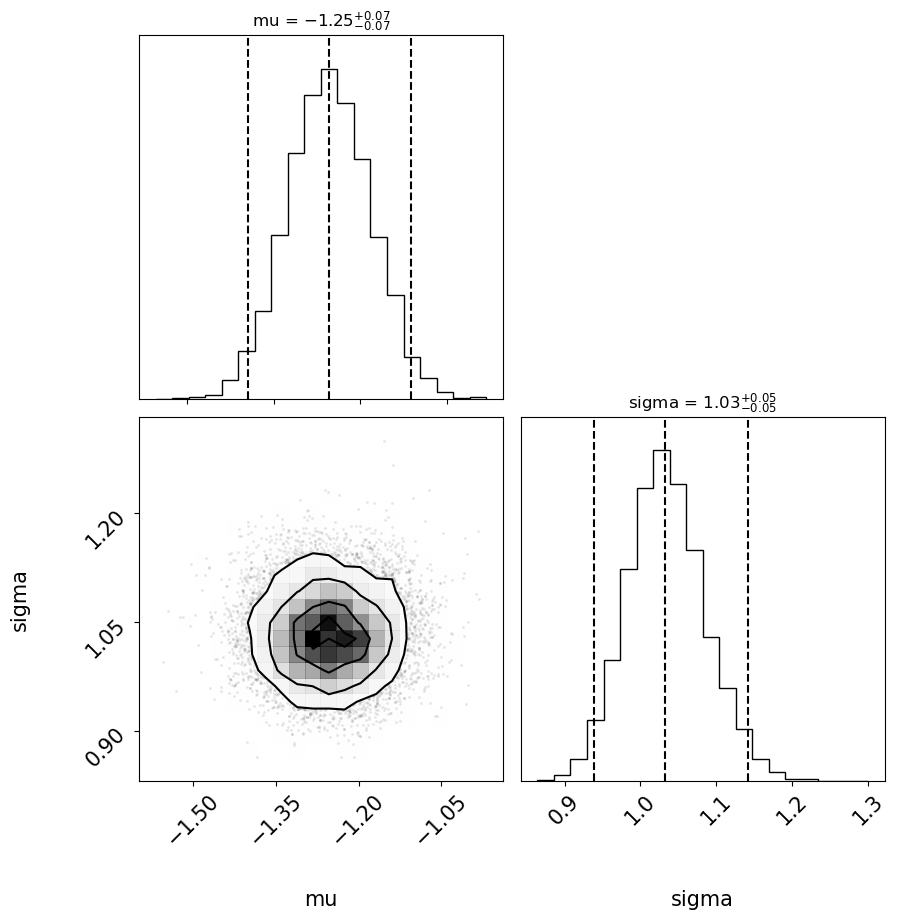

In [198]:
fig, ax = plt.subplots(2,2, figsize=(10,10))     
fig = corner.corner(trace, fig=fig, var_names=['mu', 'sigma'],
                           quantiles=[0.025, 0.5, 0.975],
                           show_titles=True, 
                           title_kwargs={"fontsize": 12})

$\mu$ and $\sigma$ seem uncorrelated.

The following aims to overplot the mean log-normal distribution over the observed density. SciPy has a bit of a deviating version of the log-normal distribution, so we need our customary function:

In [199]:
def logNormal(x, mu, sigma):
    return np.exp(-(np.log(x) - mu)**2/2/sigma**2) / x / sigma / np.sqrt(2*np.pi)

In [200]:
meanValues = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['mean']
muMean = meanValues.mu
sigmaMean = meanValues.sigma

lowerQuantiles = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['hdi_2.5%']
muLower = lowerQuantiles.mu
sigmaLower = lowerQuantiles.sigma

upperQuantiles = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['hdi_97.5%']
muUpper = upperQuantiles.mu
sigmaUpper = upperQuantiles.sigma

In [205]:
sigmaUpper

1.139

In [208]:
xvalues = np.linspace(0.01, 1.5, 100)
yvaluesMean  = logNormal(xvalues, muMean, sigmaMean)
yvaluesLower = logNormal(xvalues, muLower, sigmaLower)
yvaluesUpper = logNormal(xvalues, muUpper, sigmaUpper)

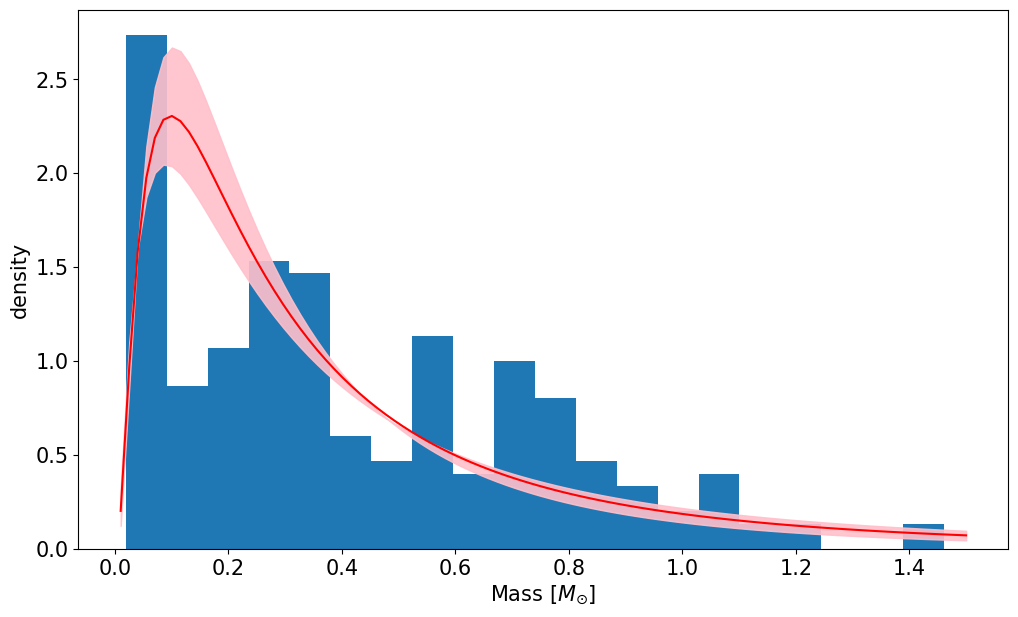

In [209]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.hist(data['Mass'].values, bins=20, density=True)

ax.fill_between(xvalues, yvaluesLower, yvaluesUpper, color="pink", alpha=0.9)
ax.plot(xvalues, yvaluesMean, c="red", linewidth=1.5)

ax.set_xlabel(r"Mass $[M_{\odot}]$")
ax.set_ylabel("density")
plt.show()

Back to [contents](#Contents).

---

## Fitting a logit model with Stan

Load the dataset:

In [100]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/Red_spirals.csv"
data = pd.read_csv(url, comment='#')

In [101]:
data.head()

redshift    g_r  g_r_err  fracdev  type
0    0.0833  0.695    0.020     0.42     1
1    0.0735  0.701    0.021     0.46     1
2    0.0642  0.756    0.039     0.00     1
3    0.0621  0.662    0.017     0.32     1
4    0.0661  0.687    0.018     0.40     1

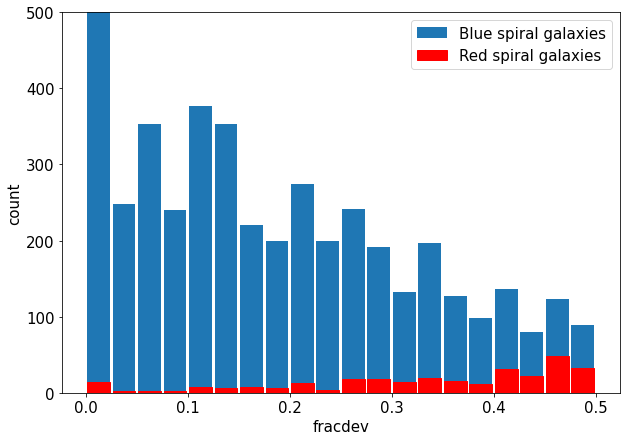

In [102]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

red = data['type'] == 1
blue = data['type'] == 0
ax.hist(data.loc[blue, 'fracdev'], bins=20, rwidth=0.9, label="Blue spiral galaxies")
ax.hist(data.loc[red, 'fracdev'], bins=20, facecolor="red", edgecolor="red", rwidth=0.9, label="Red spiral galaxies")

ax.legend(loc='upper right')
ax.set_xlabel("fracdev")
ax.set_ylabel("count")
ax.set_ylim(0, 500)
plt.show()

In [103]:
code = \
"""
data {
  int<lower=0> N;                   // Number of data points
  int<lower=0> K;                   // Number of model parameters
  matrix[N,K] X;                    // Design matrix, bulge size
  int y[N];                         // Galaxy type: 0: blue, 1: red
}

parameters {
  vector[K] theta;                  // Model parameters
}

transformed parameters {
  real intercept;                   // Separate quantities just to make the trace plots more clear
  real slope;
  
  intercept = theta[1];
  slope = theta[2];
}

model {
  for (k in 1:K) {
    theta[k] ~ normal(0,10);
  }
  
  y ~ bernoulli_logit(X * theta);   // p_i = inverse-logit(X * theta)
}
"""

In [104]:
X = np.vander(data['fracdev'].values, 2, increasing=True)
y = data['type']
myData = {'N': X.shape[0], 'K': X.shape[1], 'X': X, 'y': y}

In [105]:
model = stan.build(code, data=myData, random_seed=135)

Building...
Found model in cache. Done.


In [106]:
trace = model.sample(num_chains=4, num_samples=3000)

Sampling...
     0/16000 [>---------------------------]   0%  1 sec/0     
  1700/16000 [==>-------------------------]  10%  1 sec/7     
  6500/16000 [===========>----------------]  40% 14 secs/33    
  9700/16000 [================>-----------]  60% 18 secs/29    
 16000/16000 [============================] 100% 18 secs/18   Messages received during sampling:
  Gradient evaluation took 0.000367 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.67 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000336 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000313 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000342 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.42 seconds.
  Adjust 

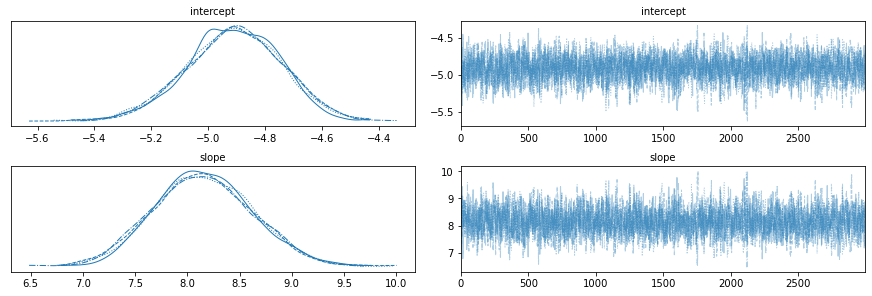

In [107]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope'])

In [108]:
az.summary(trace, var_names=['intercept', 'slope'], hdi_prob=0.95, round_to=3)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
intercept -4.911  0.168    -5.239     -4.581      0.003    0.002  2509.402   
slope      8.157  0.479     7.286      9.136      0.010    0.007  2515.797   

             ess_sd  ess_bulk  ess_tail  r_hat  
intercept  2500.883  2525.793  2988.637  1.001  
slope      2499.342  2529.884  3175.353  1.001

In [109]:
meanIntercept = np.mean(trace['intercept'])
meanSlope = np.mean(trace['slope'])
xvalues = np.linspace(0, 0.5, 100)
yvalues = 1/(1+np.exp(-meanIntercept-meanSlope*xvalues))

In [110]:
bins = np.linspace(0, 0.5, 20)
binCenters = (bins[1:] + bins[:-1])/2.

allGalaxies, dummy = np.histogram(data['fracdev'], bins=bins)
redGalaxies, dummy = np.histogram(data.loc[red, 'fracdev'], bins=bins) 
fraction = redGalaxies / allGalaxies

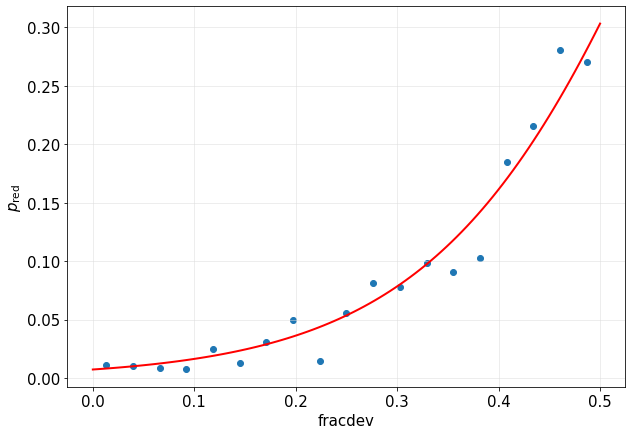

In [111]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.scatter(binCenters, fraction)
ax.plot(xvalues, yvalues, color="red", linewidth=2)
ax.set_xlabel("fracdev")
ax.set_ylabel(r"$p_{\rm red}$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Fitting a logistic model with PyMC

We use the same dataset as in the previous example:

In [210]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/Red_spirals.csv"
data = pd.read_csv(url, comment='#')

In [211]:
with pm.Model() as myModel:
    xobs = pm.Data("xobs", data['fracdev'].values)
    yobs = pm.Data("yobs", data['type'].values)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope     = pm.Normal('slope', mu=0, sigma=10)
    probRed   = pm.Deterministic('probRed', pm.math.sigmoid(intercept + slope * xobs))
    y         = pm.Bernoulli('y', p=probRed, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.


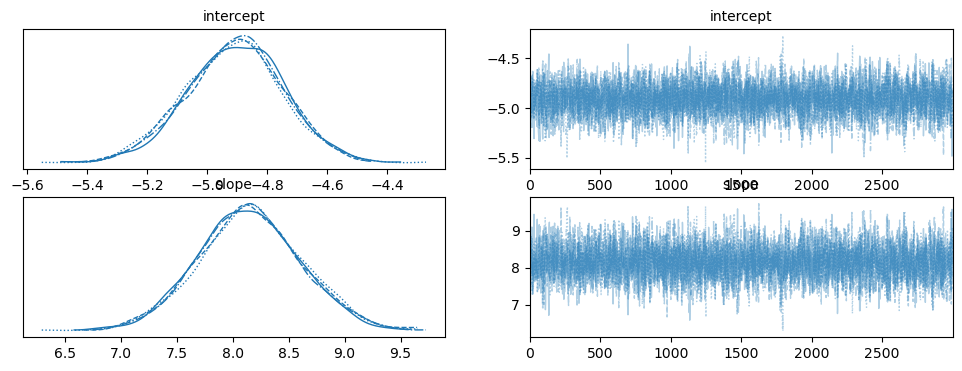

In [212]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope'])

In [213]:
az.summary(trace, var_names=['intercept', 'slope'], hdi_prob=0.95, round_to=3)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept -4.909  0.161    -5.237     -4.600      0.003    0.002  3037.839   
slope      8.151  0.462     7.252      9.059      0.008    0.006  3101.107   

           ess_tail  r_hat  
intercept  3276.679  1.001  
slope      3211.799  1.001

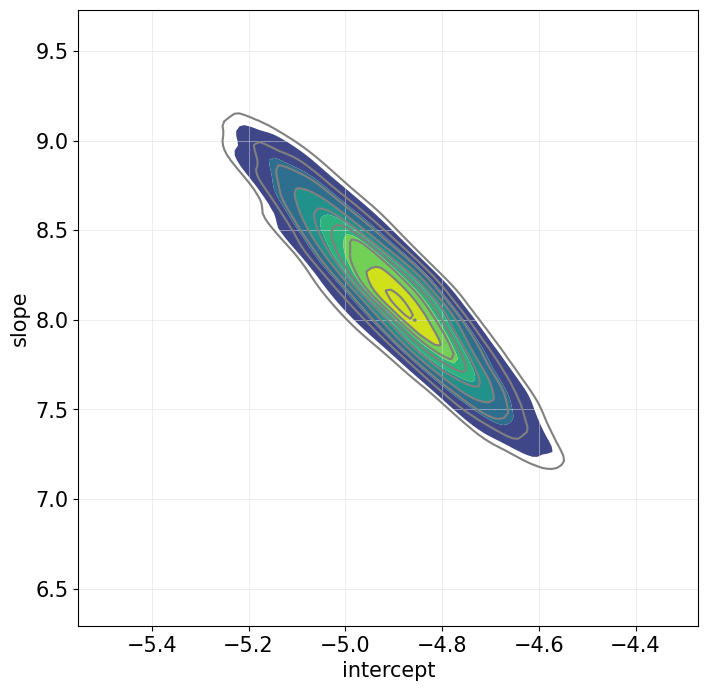

In [214]:
fig, ax = plt.subplots(1,1, figsize=(8,8)) 
kde_kwargs = {'contour_kwargs': {'levels': 10}}
az.plot_pair(trace, ax=ax, var_names=['intercept', 'slope'], kind='kde', kde_kwargs=kde_kwargs);
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5, alpha=0.7)

The mean fit:

In [215]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope
xvalues = np.linspace(0, 0.5, 100)
yvalues = 1/(1+np.exp(-meanIntercept-meanSlope*xvalues))

In [216]:
stacked = trace.posterior.stack(draws=("chain", "draw"))
slope = stacked.slope.values
intercept = stacked.intercept.values

The observed fraction of red spirals w.r.t. the total number of spiral galaxies:

In [217]:
bins = np.linspace(0, 0.5, 20)
binCenters = (bins[1:] + bins[:-1])/2.

red = data['type'] == 1
allGalaxies, dummy = np.histogram(data['fracdev'], bins=bins)
redGalaxies, dummy = np.histogram(data.loc[red, 'fracdev'], bins=bins) 
fraction = redGalaxies / allGalaxies

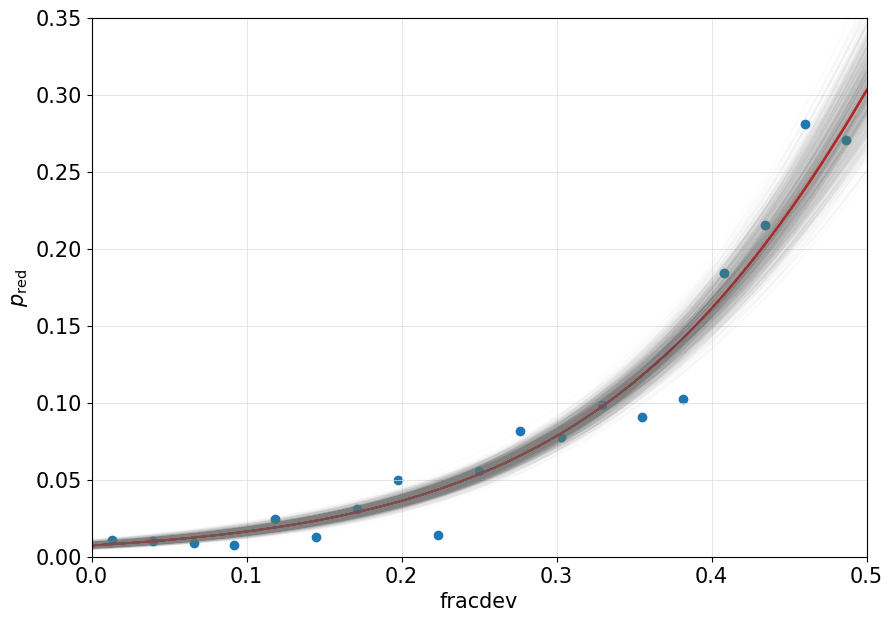

In [218]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.plot(xvalues, yvalues, c="red", linewidth=2)

M = len(slope)//1000
for n in range(0, len(slope), M):
    yvalues = 1/(1+np.exp(-intercept[n]-slope[n]*xvalues))
    ax.plot(xvalues, yvalues, c="gray", linewidth=1, alpha=0.02)

ax.scatter(binCenters, fraction)

ax.set_xlabel("fracdev")
ax.set_ylabel(r"$p_{\rm red}$")
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.35)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## A multinomial logistic model with Stan

In [121]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/AtomiumAGB5.csv"
data = pd.read_csv(url, comment='#')
data.head()

Name          Mdot  distance  class
0   S Pav  8.000000e-08       190      1
1   T Mic  8.000000e-08       210      1
2   U Del  1.500000e-07       279      2
3  RW Sco  2.100000e-07       514      2
4   V PsA  3.000000e-07       278      2

As covariate we will use the logarithm of the mass loss. For the classes we prefer the number 0,1,2 instead of 1,2,3 because several software libraries expect the latter.

In [122]:
x = np.log10(data['Mdot']).values
meanx = np.mean(x)
x = x - meanx                                             # Recentering the covariate
y = data['class'].values

In [123]:
print(meanx)

-5.9774601137129935


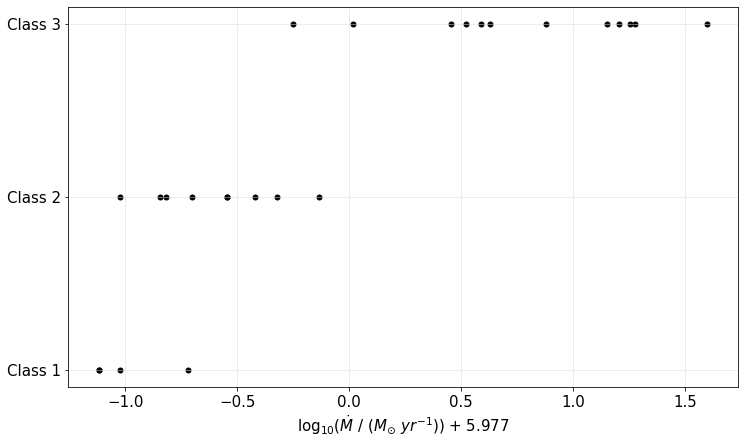

In [124]:
fig, ax = plt.subplots(1,1, figsize=(12,7))

ax.scatter(x, y, c="black",s=25)

ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_xlabel(r"$\log_{10}(\dot{M} \ / \ (M_{\odot} \ yr^{-1}))$ + 5.977")

ax.set_yticks([1,2,3])
ax.set_yticklabels(['Class 1','Class 2','Class 3'])
plt.show()

In the following Stan script we use the first class as a pivot, which means that we set its intercept and slope to zero.

In [125]:
code = \
"""
data {
    int<lower=2> J;                               // Nr of categories (classes) 
    int<lower=1> N;                               // Nr of observations
    int<lower=1> K;                               // Nr of covariates
    int<lower=1,upper=J> y[N];                    // Our categorical data
    matrix[N,K] X;                                // Design matrix  
}

transformed data {
    vector[K] zeros = rep_vector(0, K);
}

parameters {
    matrix[K, J-1] theta_raw;  
}

transformed parameters {
    matrix[K, J] theta;
    theta = append_col(zeros, theta_raw);
}

model {

    matrix[N,J] Xtheta = X * theta;

    to_vector(theta_raw) ~ normal(0, 20);
    
    for (n in 1:N) {
        y[n] ~ categorical_logit(Xtheta[n]');
    }
}
"""

In [126]:
N = len(x)                                                                       # Nr of observations
K = 2                                                                            # Nr of regression coefficients
J = 3                                                                            # Nr of categories (classes)
X = np.column_stack([np.ones_like(x), x])                                        # Design matrix
myData = {'N': N, 'K': K, 'J': J, 'X': X, 'y': y}

In [127]:
model = stan.build(code, data=myData, random_seed=835)

Building... This may take some time.
Messages from stanc:
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_12s46lur/model_vj572mxh.stan', line 27, column 37 to column 39:
  Argument 20 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Done.


In [128]:
trace = model.sample(num_chains=4, num_samples=4000)

Sampling...
     0/20000 [>---------------------------]   0%  1 sec/0     
 20000/20000 [============================] 100%  1 sec/0   Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!

 20000/20000 [============================] 100%  1 sec/0     
Done.


/Users/joris/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/Users/joris/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/Users/joris/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/Users/joris/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the 

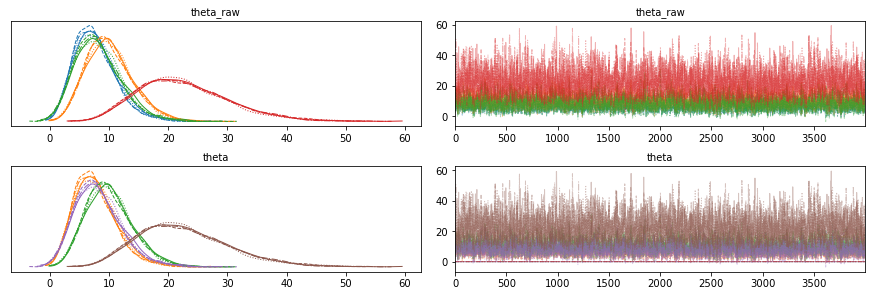

In [129]:
ax = az.plot_trace(trace)

The bandwidth problem is caused by the fact that we set the intercept and slope for the 1st class to be exact zero. Hence it cannot compute the bandwidth of the kernel density estimate as it is a delta function.

In [130]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
theta_raw[0,0]   7.681  3.623   1.448   14.452      0.068    0.048    2801.0   
theta_raw[0,1]  10.059  3.981   3.014   17.524      0.074    0.053    2859.0   
theta_raw[1,0]   8.189  3.985   1.115   15.601      0.075    0.053    2839.0   
theta_raw[1,1]  22.534  7.822   9.307   37.693      0.140    0.099    3144.0   
theta[0,0]       0.000  0.000   0.000    0.000      0.000    0.000   16000.0   
theta[0,1]       7.681  3.623   1.448   14.452      0.068    0.048    2801.0   
theta[0,2]      10.059  3.981   3.014   17.524      0.074    0.053    2859.0   
theta[1,0]       0.000  0.000   0.000    0.000      0.000    0.000   16000.0   
theta[1,1]       8.189  3.985   1.115   15.601      0.075    0.053    2839.0   
theta[1,2]      22.534  7.822   9.307   37.693      0.140    0.099    3144.0   

                 ess_sd  ess_bulk  ess_tail  r_hat  
theta_raw[0,0]   2798.0    2874.0    4052.0    1.0  
theta_raw[0,1]   2859.0    2872.0    4340.0    1.0  
theta_raw[1,0]   2839.0    2900.0    4192.0    1.0  
theta_raw[1,1]   3138.0    3186.0    4514.0    1.0  
theta[0,0]      16000.0   16000.0   16000.0    NaN  
theta[0,1]       2798.0    2874.0    4052.0    1.0  
theta[0,2]       2859.0    2872.0    4340.0    1.0  
theta[1,0]      16000.0   16000.0   16000.0    NaN  
theta[1,1]       2839.0    2900.0    4192.0    1.0  
theta[1,2]       3138.0    3186.0    4514.0    1.0

In [131]:
meanTheta = az.summary(trace)['mean']
meanTheta = np.array([meanTheta['theta[{0},{1}]'.format(k,j)] for k in range(K) for j in range(J)]).reshape(K,J)
print(meanTheta)

[[ 0.     7.681 10.059]
 [ 0.     8.189 22.534]]


In [132]:
xvalues = np.linspace(-1.6, 1.7, 200)
Xdesign = np.column_stack([np.ones_like(xvalues), xvalues])
expXtheta = np.exp(np.dot(Xdesign, meanTheta))
P2 = expXtheta[:,1] / expXtheta.sum(axis=1)
P3 = expXtheta[:,2] / expXtheta.sum(axis=1)
P1 = 1-P2-P3

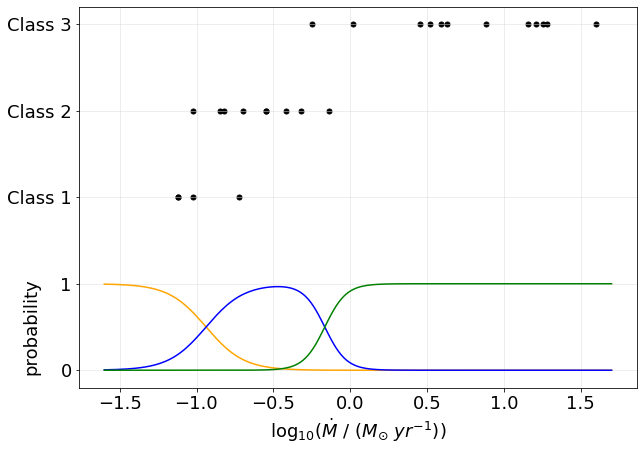

In [133]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel(r'$\log_{10}(\dot{M} \ / \ (M_{\odot} \ yr^{-1}))$', fontsize=18)
ax.set_ylabel('probability', fontsize=18)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xvalues, P1, c="orange")
ax.plot(xvalues, P2, c="blue")
ax.plot(xvalues, P3, c="green")
ax.scatter(x, y+1, c="black", s=25)

plt.show()

For comparison we do the same multinomial logistic regression using the `statsmodels` library. Also here we use P1 as a pivot.

In [134]:
myModel = sm.MNLogit(y, X)
myFit = myModel.fit(method="powell")
print(myFit.summary())

Optimization terminated successfully.
         Current function value: 0.292120
         Iterations: 8
         Function evaluations: 360
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                   25
Model:                        MNLogit   Df Residuals:                       21
Method:                           MLE   Df Model:                            2
Date:                Thu, 06 May 2021   Pseudo R-squ.:                  0.7117
Time:                        02:44:42   Log-Likelihood:                -7.3030
converged:                       True   LL-Null:                       -25.333
Covariance Type:            nonrobust   LLR p-value:                 1.478e-08
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4603      4.134      1.805      0.071      -0.641      

In [135]:
expXbeta = np.exp(np.dot(Xdesign, myFit.params))
P2 = expXbeta[:,0] / (1 + expXbeta.sum(axis=1))
P3 = expXbeta[:,1] / (1 + expXbeta.sum(axis=1))
P1 = 1-P2-P3

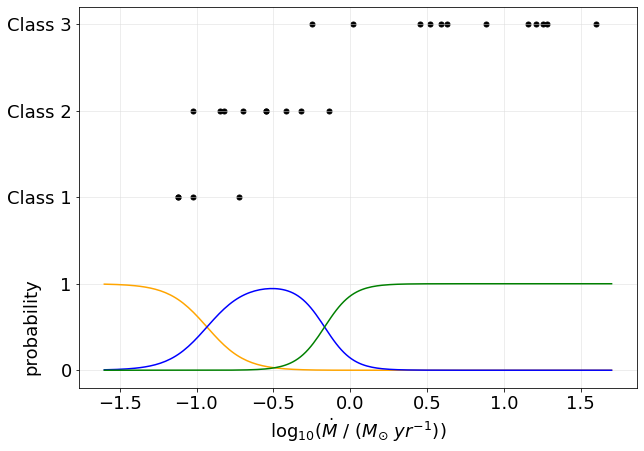

In [136]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel(r'$\log_{10}(\dot{M} \ / \ (M_{\odot} \ yr^{-1}))$', fontsize=18)
ax.set_ylabel('probability', fontsize=18)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xvalues, P1, c="orange")
ax.plot(xvalues, P2, c="blue")
ax.plot(xvalues, P3, c="green")
ax.scatter(x, y+1, c="black", s=25)

plt.show()

Back to [contents](#Contents).

---

## Modeling a fraction with the Beta distribution with Stan

In [137]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/f_gas.csv"
data = pd.read_csv(url, comment='#')
data.head()

NSAID           RA           DEC   DISTANCE  DISTANCE_ERR  INCLINATION  \
0    162  09:58:30.23  +00:02:42.72  30.230679      1.893556           71   
1   1443  12:23:09.98  +00:25:37.76  35.361080      2.000777           68   
2   5109  22:30:36.80  -00:06:37.01  21.256725      1.857816           28   
3   5378  23:06:39.16  +00:34:41.02  68.131355      2.393957           70   
4   5424  23:14:19.43  +00:10:59.36  60.297279      1.750601           88   

      V_W20I  V_W20I_ERR     R_EFF  R_EFF_ERR          M_HI     M_HI_ERR  \
0  40.484997    3.175172  0.718135   0.044982  1.051982e+08   29240232.0   
1  26.163080   13.456303  0.863503   0.048858  4.139277e+07   18685420.0   
2  77.564659    3.161093  0.285932   0.024990  6.664611e+07   24189620.0   
3  61.939968    2.134023  1.818062   0.063882  1.039202e+09  166114256.0   
4  63.627235    3.002364  1.771058   0.051419  4.048609e+08   58240672.0   

        M_STAR   M_STAR_ERR  SOURCE  
0   16153380.0    7440246.5       1  
1   43087828.0   19846254.0       1  
2    7706057.5    3549410.0       3  
3  273271296.0  125868760.0       1  
4  611754560.0  281774176.0       1

In [138]:
gasFraction = data['M_HI'].values / (data['M_HI'].values + data['M_STAR'].values)
x = np.log10(data['M_STAR'].values)
myData = {'N': len(x), 'x': x, 'y': gasFraction}

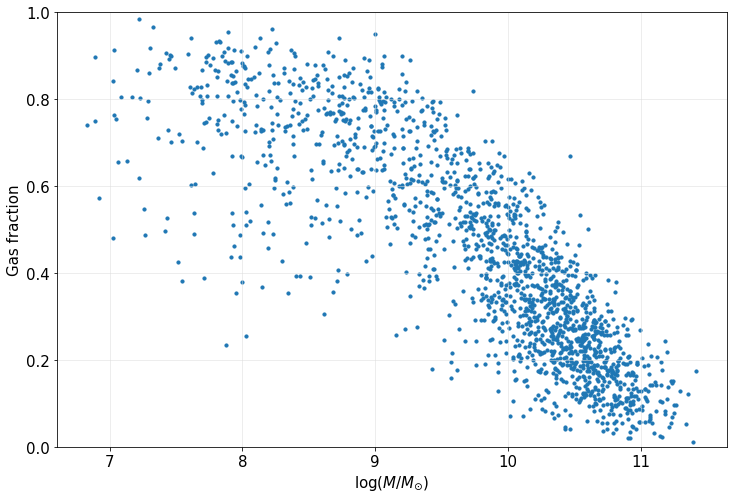

In [139]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(np.log10(data['M_STAR']), gasFraction, s=10)
ax.set_ylabel("Gas fraction")
ax.set_xlabel(r"$\log(M/M_{\odot})$")
ax.set_ylim(0,1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

In [140]:
Nnew = 100
xnew = np.linspace(6.5, 11.5, Nnew)
myData['Nnew'] = Nnew
myData['xnew'] = xnew

The Stan script:

In [141]:
code = \
"""
data {
    int<lower=0> N;                                   // Number of observations
    real x[N];                                        // log10(mass)
    real<lower=0, upper=1> y[N];                      // Gas fraction observations
    int<lower=0> Nnew;                                // To compute posterior prediction interval
    real xnew[Nnew]; 
}

parameters {
    real intercept;
    real slope;
    real<lower=0> kappa;                              // Beta distribution parameter
}

model {
    
    vector[N] mu;                                     // Mean of the beta distribution
    
    for (n in 1:N) {
        mu[n] = inv_logit(intercept + slope * x[n]);
    }
    
    intercept ~ normal(0, 20);
    slope ~ normal(0, 20);
    kappa ~ student_t(4,0,1);
    
    y ~ beta_proportion(mu, kappa);
}

generated quantities {
    
    real aa[Nnew];
    real bb[Nnew];
    real eta[Nnew];
    
    for (n in 1:Nnew) {
        eta[n] = inv_logit(intercept + slope * xnew[n]); 
        aa[n] = eta[n] * kappa;
        bb[n] = (1-eta[n]) * kappa;
    }
    real ynew[Nnew] = beta_rng(aa, bb);
}
"""

In [142]:
model = stan.build(code, data=myData, random_seed=13593)

Building... This may take some time.
Messages from stanc:
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_c2sohbgm/model_cqnaxf22.stan', line 24, column 26 to column 28:
  Argument 20 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Warning at '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_c2sohbgm/model_cqnaxf22.stan', line 25, column 22 to column 24:
  Argument 20 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Done.


In [143]:
trace = model.sample(num_chains=4, num_samples=4000)

Sampling...
     0/20000 [>---------------------------]   0%  1 sec/0     
   202/20000 [>---------------------------]   1%  1 sec/101   
   500/20000 [>---------------------------]   2% 3 secs/81    
   900/20000 [=>--------------------------]   4% 4 secs/68    
  1200/20000 [=>--------------------------]   6% 5 secs/69    
  1600/20000 [==>-------------------------]   8% 6 secs/64    
  1900/20000 [==>-------------------------]   9% 7 secs/65    
  2400/20000 [===>------------------------]  12% 8 secs/60    
  2700/20000 [===>------------------------]  13% 9 secs/61    
  3100/20000 [====>-----------------------]  15% 10 secs/60    
  3601/20000 [=====>----------------------]  18% 11 secs/57    
  3802/20000 [=====>----------------------]  19% 12 secs/60    
  4004/20000 [=====>----------------------]  20% 12 secs/59    
  4004/20000 [=====>----------------------]  20% 13 secs/64    
  4103/20000 [=====>----------------------]  20% 14 secs/68    
  4301/20000 [======>----------------

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_proportion_lpdf: Location parameter[1] is 0, but must be positive! (in '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_ypu7x9b_/model_cqnaxf22.stan', line 28, column 4 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_proportion_lpdf: Location parameter[1] is 0, but must be 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_proportion_lpdf: Location parameter[1] is 1, but must be less than 1 (in '/var/folders/mv/9dl7q0vx38g3d89v7g75zgfwdpknxw/T/httpstan_ypu7x9b_/model_cqnaxf22.stan', line 28, column 4 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_proportion_lpdf: Location parameter[1] is 1, but must b

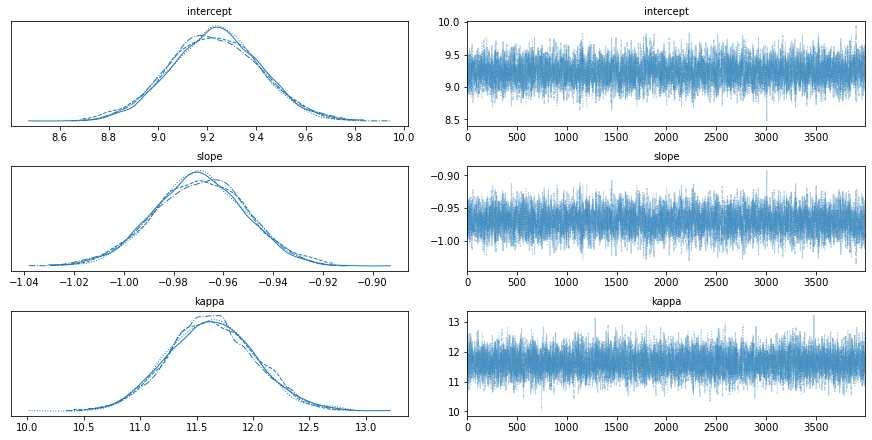

In [144]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'kappa'])

In [145]:
meanIntercept = np.mean(trace['intercept'])
meanSlope = np.mean(trace['slope'])
xvalues = np.linspace(6.5, 11.5, 100)
yvalues = 1/(1+np.exp(-meanIntercept-meanSlope*xvalues))

In [146]:
median = np.quantile(trace['ynew'], 0.5, axis=1)
lowerQuantile = np.quantile(trace['ynew'], 0.025, axis=1)
upperQuantile = np.quantile(trace['ynew'], 0.975, axis=1)

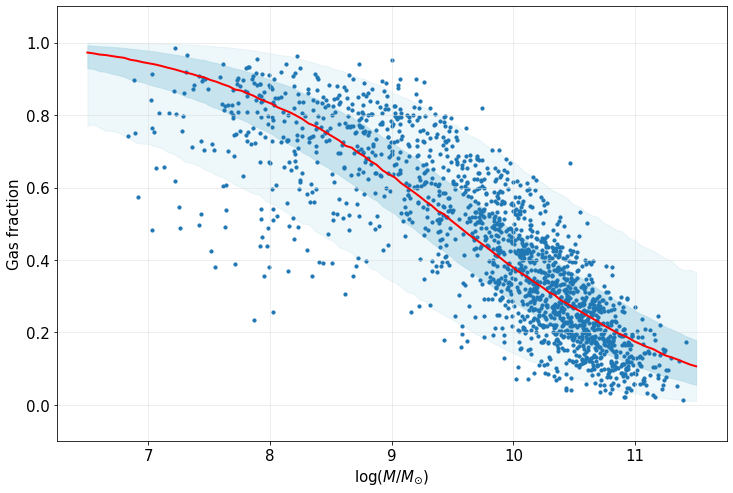

In [147]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

median = np.quantile(trace['ynew'], 0.5, axis=1)
ax.plot(xnew, median, c="red", linewidth=2)

lowerQuantile = np.quantile(trace['ynew'], 0.025, axis=1)                              # 95% prediction interval
upperQuantile = np.quantile(trace['ynew'], 0.975, axis=1)
ax.fill_between(xnew, lowerQuantile, upperQuantile, color="lightblue", alpha=0.2)

lowerQuantile = np.quantile(trace['ynew'], 0.25, axis=1)                               #  50% prediction interval    
upperQuantile = np.quantile(trace['ynew'], 0.75, axis=1)
ax.fill_between(xnew, lowerQuantile, upperQuantile, color="lightblue", alpha=0.6)

ax.scatter(np.log10(data['M_STAR']), gasFraction, s=10)

ax.set_ylabel("Gas fraction")
ax.set_xlabel(r"$\log(M/M_{\odot})$")
ax.set_ylim(-0.1, 1.1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling counts with Poisson with PyMC

In [219]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')
data.head()

N_GC   MV_T Type
0   160 -21.30    S
1     1 -14.84  Irr
2   150 -20.18    S
3    36 -18.77    S
4    10 -15.46    E

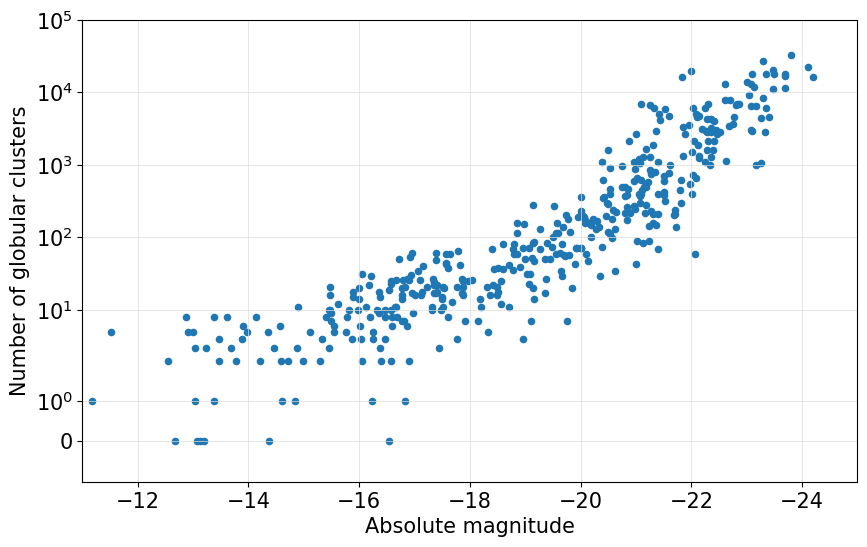

In [222]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(data['MV_T'], data['N_GC'], s=20)
ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The PyMC model:

In [224]:
with pm.Model() as myModel:
    xobs = pm.Data("xobs", data['MV_T'].values)
    yobs = pm.Data("yobs", data['N_GC'].values)
    intercept  = pm.Normal('intercept', mu=0, sigma=40)
    slope      = pm.Normal('slope', mu=0, sigma=40)
    mu         = np.exp(intercept + slope * xobs)
    y          = pm.Poisson('y', mu=mu, observed=yobs)

    N = len(data['N_GC'].values)
    K = 2
    dispersion = pm.Deterministic('dispersion', pt.sum((yobs-mu)**2 / mu) / (N-K))

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, random_seed=3941592)

/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 12 seconds.


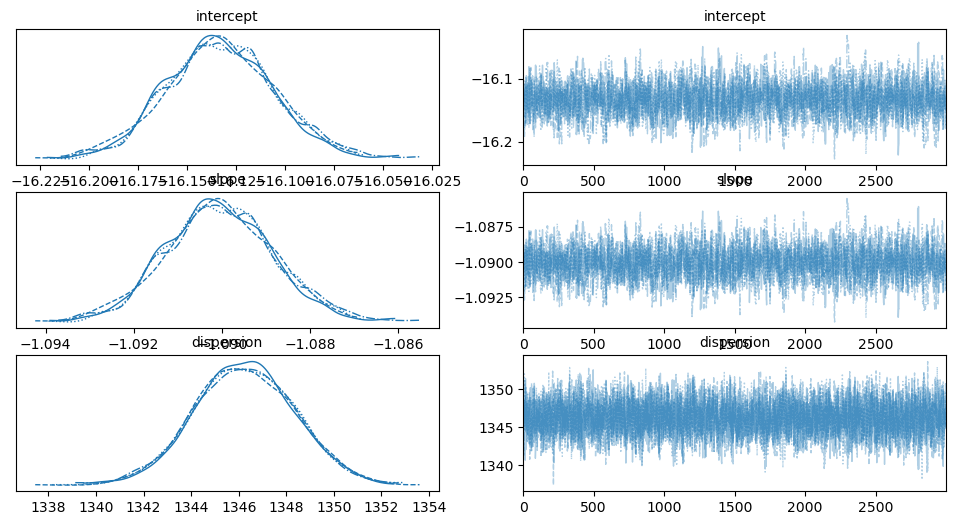

In [225]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'dispersion'])

In [226]:
az.summary(trace, var_names=['intercept', 'slope', 'dispersion'], hdi_prob=0.95, round_to=3)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
intercept    -16.133  0.027   -16.185    -16.076      0.001    0.000   
slope         -1.090  0.001    -1.092     -1.088      0.000    0.000   
dispersion  1346.247  2.101  1342.117   1350.331      0.033    0.023   

            ess_bulk  ess_tail  r_hat  
intercept   1827.042  1676.662  1.002  
slope       1823.811  1667.870  1.002  
dispersion  4007.833  5205.147  1.000

In [227]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

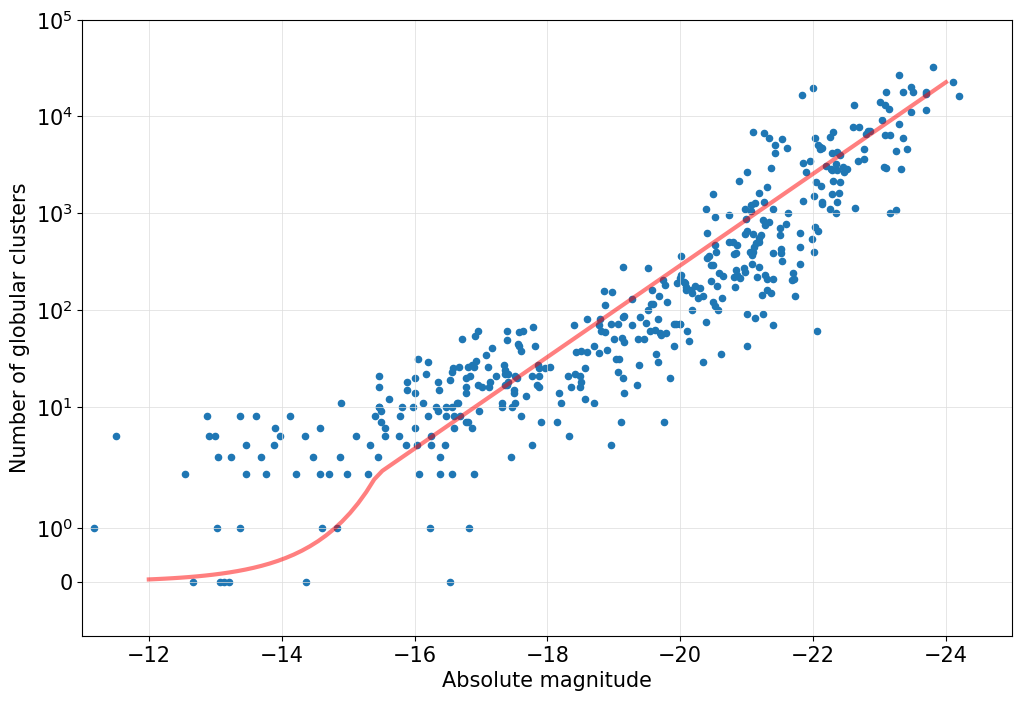

In [229]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(data['MV_T'], data['N_GC'], s=20)

xvalues = np.linspace(-24, -12, 100)
yvalues = np.exp(meanIntercept + meanSlope * xvalues)
ax.plot(xvalues, yvalues, c="red", linewidth=3, alpha=0.5)

ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1.0, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling counts with Poisson with Stan

We use the same dataset as in the previous example:

In [155]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')

The Stan script:

In [156]:
code = \
"""
data {
   int<lower=0> N;                   // Number of data points
   int<lower=0> K;                   // Number of model parameters
   matrix[N,K] X;                    // Design matrix
   int y[N];                         // Globular cluster counts
}

parameters {
   vector[K] theta;                  // Model parameters
}

transformed parameters {
   real intercept;                   // Separate quantities just to make the trace plots more clear
   real slope;
  
   intercept = theta[1];
   slope = theta[2];
}

model {
   y ~ poisson_log(X * theta);       // Poisson with mu = exp(X*theta)
}
"""

In [157]:
X = sm.add_constant(np.column_stack([data['MV_T'].values]))                         # Design matrix
myData = {'X': X, 'y': data['N_GC'].values, 'N': X.shape[0], 'K': X.shape[1]}

In [158]:
model = stan.build(code, data=myData, random_seed=135)

Building...
Messages from stanc:
  The parameter theta has no priors.
Found model in cache. Done.


In [159]:
trace = model.sample(num_chains=4, num_samples=5000)

Sampling...
     0/24000 [>---------------------------]   0%  1 sec/0     
  6900/24000 [========>-------------------]  28% 6 secs/18    
 24000/24000 [============================] 100% 6 secs/5   Messages received during sampling:
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!

 24000/24000 [============================] 100% 6 secs/5     
Done.


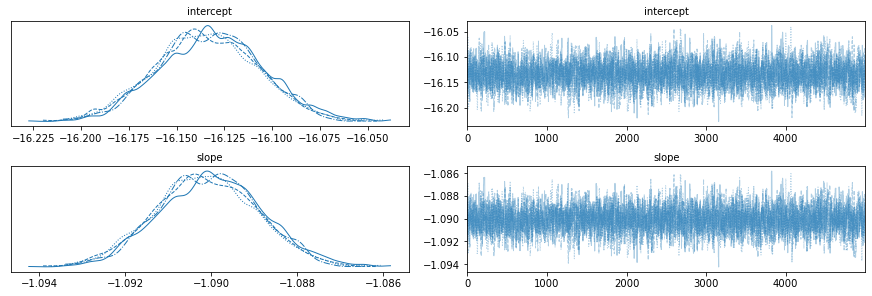

In [160]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope'])

In [161]:
az.summary(trace, var_names=['intercept', 'slope'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
intercept -16.133  0.027 -16.184  -16.083      0.001      0.0    2704.0   
slope      -1.090  0.001  -1.092   -1.088      0.000      0.0    2709.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
intercept  2704.0    2694.0    2932.0    1.0  
slope      2709.0    2700.0    2982.0    1.0

Back to [contents](#Contents).

---

## Modeling counts with Negative Binomial with PyMC

In [230]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')

In [233]:
with pm.Model() as myModel:
    
    xobs       = pm.Data("xobs", data['MV_T'].values)
    yobs       = pm.Data("yobs", data['N_GC'].values)
    intercept  = pm.Normal('intercept', mu=0, sigma=40)
    slope      = pm.Normal('slope', mu=0, sigma=40)
    mu         = np.exp(intercept + slope * xobs)
    alpha      = pm.Uniform('alpha', 0, 5)
    y          = pm.NegativeBinomial('y', mu=mu, alpha=alpha, observed=yobs)
    var        = pm.Deterministic('variance', mu * (1+mu/alpha))

    N = len(data['N_GC'].values)
    K = 3
    dispersion = pm.Deterministic('dispersion', pt.sum((yobs-mu)**2 / var) / (N-K))

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, random_seed=341592)

/Users/joris/miniconda3/envs/course/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, slope, alpha]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 16 seconds.


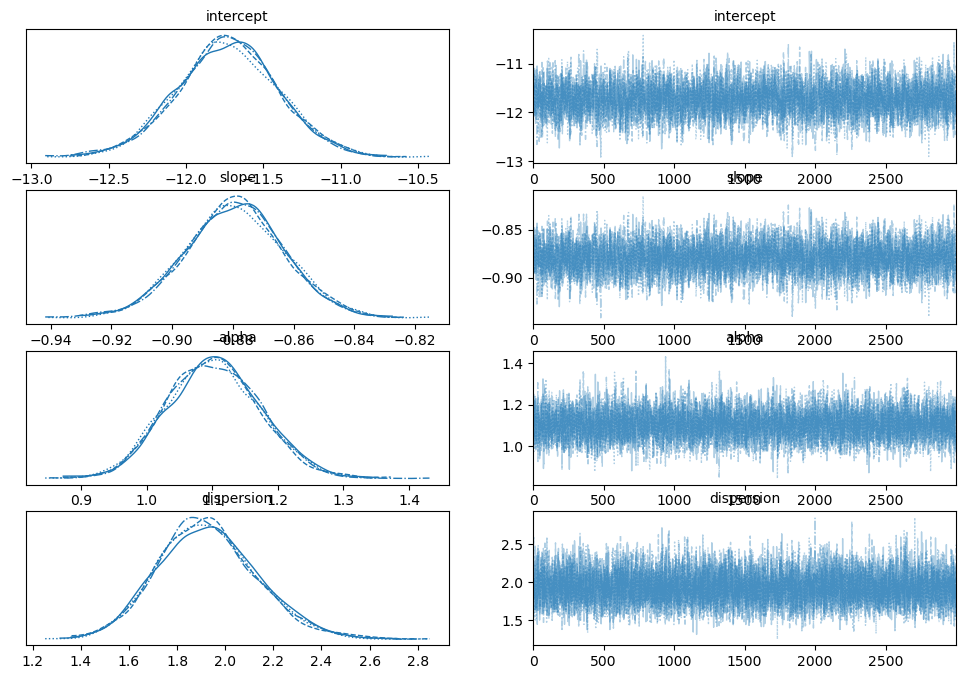

In [234]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'alpha', 'dispersion'])

The model is still slightly overdispersed, but we can't exclude that this is caused by the fact that we somewhat misspecified our model. 

In [235]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

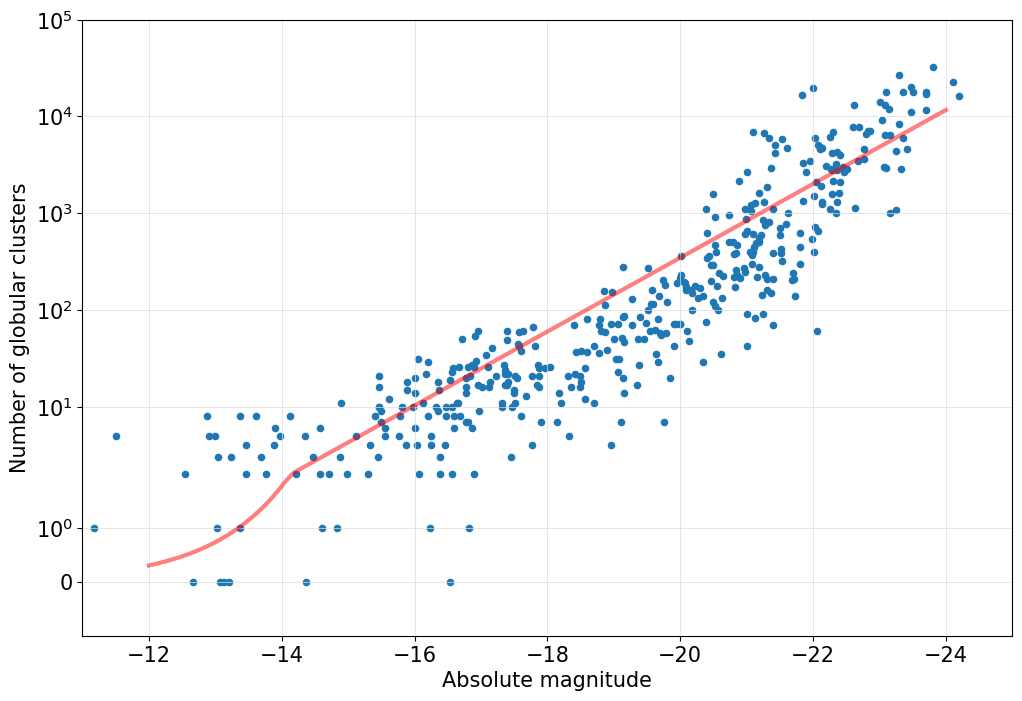

In [236]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(data['MV_T'], data['N_GC'], s=20)

xvalues = np.linspace(-24, -12, 100)
yvalues = np.exp(meanIntercept + meanSlope * xvalues)
ax.plot(xvalues, yvalues, c="red", linewidth=3, alpha=0.5)

ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling counts with Negative Binomial with Stan

In [167]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')

The Stan script:

In [168]:
code = \
"""
data {
   int<lower=0> N;                   // Number of data points
   int<lower=0> K;                   // Number of model parameters
   matrix[N,K] X;                    // Design matrix
   int y[N];                         // Observed globular cluster counts
}

parameters {
   vector[K] theta;                  // Model coefficients of the straight line
   real<lower=1e-3, upper=5> alpha;  // Negative Binomial parameter
}

transformed parameters {
   real intercept;                   // Separate quantities just to make the trace plots more clear
   real slope;
  
   intercept = theta[1];
   slope = theta[2];
}

model {
   y ~ neg_binomial_2_log(X * theta, alpha);       // Negative binomial with mu = exp(X*theta)
}

generated quantities {
   real dispersion;
   vector[N] mu;
   vector[N] variance;
   vector[N] PearsonResiduals;
   
   mu = exp(X * theta);
   for (n in 1:N) {
      variance[n] = mu[n] * (1 + mu[n]/alpha);
      PearsonResiduals[n] = pow(y[n] - mu[n], 2) / variance[n];
   }
   
   dispersion = sum(PearsonResiduals) / (N - K - 1);
}
"""

A lower value of 0 for alpha would lead to infinities, hence I avoid it.

In [169]:
X = sm.add_constant(np.column_stack([data['MV_T'].values]))                         # Design matrix
myData = {'X': X, 'y': data['N_GC'].values, 'N': X.shape[0], 'K': X.shape[1]}

In [170]:
model = stan.build(code, data=myData, random_seed=135)

Building...
Messages from stanc:
  The parameter alpha has no priors.
  The parameter theta has no priors.
  Your Stan program has a parameter alpha with a lower and upper bound in its
  declaration. These hard constraints are not recommended, for two reasons:
  (a) Except when there are logical or physical constraints, it is very
  unusual for you to be sure that a parameter will fall inside a specified
  range, and (b) The infinite gradient induced by a hard constraint can cause
  difficulties for Stan's sampling algorithm. As a consequence, we recommend
  soft constraints rather than hard constraints; for example, instead of
  constraining an elasticity parameter to fall between 0, and 1, leave it
  unconstrained and give it a normal(0.5,0.5) prior distribution.
Found model in cache. Done.


In [171]:
trace = model.sample(num_chains=4, num_samples=5000)

Sampling...
     0/24000 [>---------------------------]   0%  1 sec/0     
  2000/24000 [==>-------------------------]   8%  1 sec/13    
  2500/24000 [==>-------------------------]  10%  1 sec/11    
  8400/24000 [=========>------------------]  35% 44 secs/125   
 13800/24000 [================>-----------]  57% 48 secs/82    
 24000/24000 [============================] 100% 48 secs/47   Messages received during sampling:
  Gradient evaluation took 0.000107 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.0001 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000135 seconds
  1000 transitions using 10 leapfr

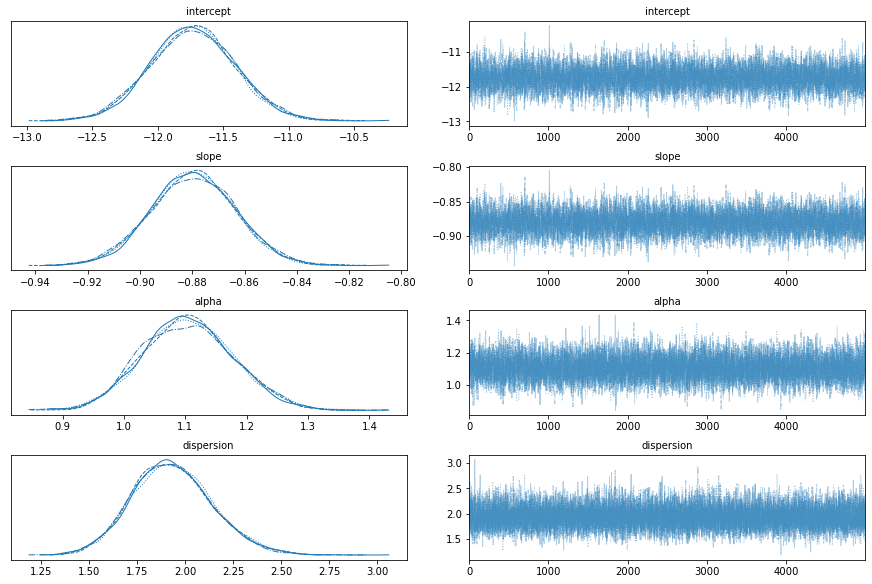

In [172]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'alpha', 'dispersion'])

Back to [contents](#Contents).

---

## A zero-truncated Poisson model with Stan

Create an artificial dataset:

In [13]:
y = sp.stats.poisson.rvs(mu=2.5, size=200)
y = y + 1                                                     # No zeros in our dataset 

In [14]:
myData = {'N': len(y), 'y': y}

The Stan script: 

In [16]:
code = \
"""
data {
   int N;
   int<lower=1> y[N];                                   // Our observed counts dataset
}

parameters {
   real<lower=0> lambda;
}

model {

   lambda ~ cauchy(0,5);                                // Half-cauchy prior

   for (n in 1:N) {
      y[n] ~ poisson(lambda)  T[1,];                    // Truncator flag T[low, high]
   }
}
"""

In [17]:
model = stan.build(code, data=myData, random_seed=1325)

Building... This may take some time.
Done.


In [18]:
trace = model.sample(num_chains=4, num_samples=3000)

Sampling...
     0/16000 [>---------------------------]   0%  1 sec/0     
 16000/16000 [============================] 100%  1 sec/0   Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!

 16000/16000 [============================] 100%  1 sec/0     
Done.


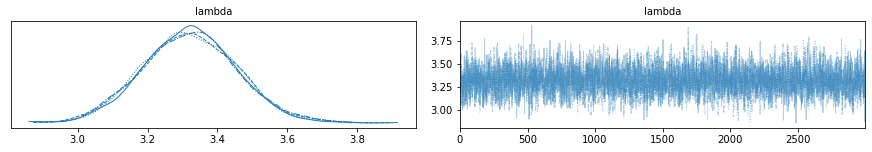

In [19]:
ax = az.plot_trace(trace)

In [20]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
lambda  3.321  0.134   3.072    3.572      0.002    0.001    4273.0  4273.0   

        ess_bulk  ess_tail  r_hat  
lambda    4270.0    5654.0    1.0

Back to [contents](#Contents).

---